In [1]:
import math
import pickle
import os
import numpy as np
import pandas as pd
from numpy.linalg import inv,pinv
import matplotlib.pyplot as plt
import sys
from IPython import display
import time
from sklearn.svm import SVR

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

%matplotlib inline

def makeBinsSc(anglErs,numBins=200,resInd=1):
    binBorders=np.linspace(-0.35,
                           0.35,numBins+1).reshape(-1,1)
    extreme=np.array([min(anglErs [:,0] ),max(anglErs[:,0])]).reshape(-1,1)
    binBorders=np.concatenate((extreme[:1], 
                               binBorders, extreme[1:]  ))
    print('binBorcders',binBorders)
    binRes=np.zeros((numBins+2,3))
    for ind,bord in enumerate(binBorders[1:]):
        koiAers=anglErs[anglErs[:,0]<=bord]
        binRes[ind]=np.var(koiAers[:,resInd]),len(koiAers),np.average(koiAers[:,resInd])
        
        anglErs=anglErs[anglErs[:,0]>bord]
    return np.hstack((binBorders[1:],binRes))
def makeBins(anglErs,numBins=200,resInd=1):
    binBorders=np.linspace(min(anglErs [:,0] ),
                           max(anglErs[:,0]),numBins+1).reshape(-1,1)
#     extreme=np.array([min(anglErs [:,0] ),max(anglErs[:,0])]).reshape(-1,1)
#     binBorders=np.concatenate((extreme[:1], 
#                                binBorders, extreme[1:]  ))
#     print('binBorcders',binBorders)
    binRes=np.zeros((numBins,3))
    for ind,bord in enumerate(binBorders[1:]):
        koiAers=anglErs[anglErs[:,0]<=bord]
        binRes[ind]=np.var(koiAers[:,resInd]),len(koiAers),np.average(koiAers[:,resInd])
        
        anglErs=anglErs[anglErs[:,0]>bord]
    print('bin shapes',binBorders[1:].reshape(-1,1).shape, binRes[:,2].shape)
        
    model = make_pipeline(PolynomialFeatures(2), Ridge())
    avgParab=model.fit(binBorders[1:].reshape(-1,1), binRes[:,2].flatten()).predict(binBorders[1:].reshape(-1,1)).reshape(-1,1)
    
    model = make_pipeline(PolynomialFeatures(2), Ridge())
    varParab=model.fit(binBorders[1:].reshape(-1,1), binRes[:,0].flatten()).predict(binBorders[1:].reshape(-1,1)).reshape(-1,1) 
    
    return np.hstack((binBorders[1:],binRes,varParab,avgParab))


class binTable:
    # 1 is noise var ,2 is bin length,3 is noise average,4 is noise var parabola,5 is average parabola
    def __init__(self,table=None,alternate=None):
        self.table=table
        self.alternate=alternate
        if self.alternate is not None:
            return
        self.nBin=len(table)
        self.first=table[0,0]
        self.last=table[-1,0]
        self.dif=table[1,0]-table[0,0]
    def getNoise(self,angl=None):
        if self.alternate is not None:
            return self.alternate
        uncbinNum=((angl-self.first)/self.dif)
        binNum=int(np.ceil( np.clip(uncbinNum,0,self.nBin-1)))
        return self.table[binNum,4]
    def getGoodMeasDist(self,angl):
        uncbinNum=((angl-self.first)/self.dif)
        binNum=int(np.ceil( np.clip(uncbinNum,0,self.nBin-1)))
        return self.table[binNum,5]
    
def getAllMulti(dI,Ri=3):

    
    oName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Odometry.dat'.format(dI,Ri)
    mName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Measurement.dat'.format(dI,Ri)
    gName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Groundtruth.dat'.format(dI,Ri)
    lName='datasets/all_data/MRCLAM_Dataset{}/Landmark_Groundtruth.dat'.format(dI,Ri)
    bName='datasets/all_data/MRCLAM_Dataset{}/Barcodes.dat'.format(dI)

    namesOdom="Time[s]    forward_velocity[m/s]    angular_velocity[rad/s]".split()
    odom=pd.read_csv(oName,sep=r"\s*",skiprows=4,names=namesOdom,engine='python')

    namesMeas="Time[s]    Subject_#    range[m]    bearing[rad]".split()
    meas=pd.read_csv(mName,sep=r"\s*",skiprows=4,names=namesMeas,engine='python')

    namesGroun="Time[s]    x[m]    y[m]    orientation[rad]".split()
    groun=pd.read_csv(gName,sep=r"\s*",skiprows=4,names=namesGroun,engine='python')

    namesLand=" Subject#    x[m]    y[m]    xstd-dev[m]    ystd-dev[m]".split()
    land=pd.read_csv(lName,sep=r"\s*",skiprows=4,names=namesLand,engine='python')

    namesBar=" Subject#    Barcode#".split()
    bar=pd.read_csv(bName,sep=r"\s*",skiprows=4,names=namesBar,engine='python')

    odom=np.array(odom.values)
    meas=np.array(meas.values)
    groun=np.array(groun.values)
    land=np.array(land.values)
    bar=np.array(bar.values)
    
    barDik={int(row[0]):int(row[1]) for row in bar}
    landDik={barDik[int(row[0])]:row[1:3] for row in land}
    
    return odom,meas,groun,landDik

In [2]:
"Plot Distrib for measur error by angle"
saveErrorAng,doAnglErrPlot,doAnglErrSum=False,False,False

if doAnglErrSum:
    angleError=[np.zeros((0,3)) for i in range(40)]
    distErr=[np.zeros((0,3)) for i in range(40)]
    RobotI=2

    for RobotI in range(40):
        odom,meas,groun,landDik=getAllMulti((RobotI//5)+1,(RobotI%5)+1)
        resDif,kolkuNeprovereni=getMultiMeasDif((RobotI//5)+1,(RobotI%5)+1 )

        measLand=np.array([i for ind,i in enumerate(meas) if int(i[1]) in landDik])
        measLandR=measLand
        if len(kolkuNeprovereni)>=1:
            measLandR=measLand[:-len(kolkuNeprovereni)]
        print('angle shapes',measLandR[:,3].reshape((-1,1)).shape,resDif.shape,len(kolkuNeprovereni))
        angleErrorI=np.hstack((measLandR[:,3].reshape((-1,1)),resDif))


        angleError[RobotI]=np.vstack((angleError[RobotI],angleErrorI))

        distErrI=np.hstack((measLandR[:,2].reshape((-1,1)),resDif))
        distErr[RobotI]=np.vstack((distErr[RobotI],distErrI))

        #print(angleError.shape,distErr.shape,flush=True)


if doAnglErrPlot:
#     plt.figure(figsize=(20,20))
#     plt.subplot(211)
#     plt.title("Distance error by measurement angle")
#     plt.scatter(distErr[:,0],distErr[:,1])
#     plt.subplot(212)
#     plt.title("Angle error by measurement angle")
#     plt.scatter(distErr[:,0],distErr[:,2])
    
    plt.figure(figsize=(10,9))
#     plt.subplot(211)
    plt.title("Distance error based on measurement angle,\n for all robots in the experiment")

    plt.scatter(angleError[:,0],angleError[:,1])
    plt.xlabel("Angle of Measurement [rad]")
    plt.ylabel("Distance Error [m]")
#     plt.subplot(212)
#     plt.title("Angle error by measurement angle")
#     plt.scatter(angleError[:,0],angleError[:,2])
    
    if saveErrorAng:
        plt.savefig("meas_dist.png",dpi=200)

In [3]:
saveAngleErr=False
if saveAngleErr:
    with open('saved_angle_dist_sepR.bins','wb') as f:
        pickle.dump((angleError,distErr),f)

all variances [ 0.15121522  0.09268653] [ 0.15121522  0.09268653]
start len 232306
end len 0.0
now var dist [ 0.15121522  0.09268653]
bin shapes (150, 1) (150,)
percentile length inside bin [  211.           572.26315789   931.36842105  1047.57894737  1130.73684211
  1246.73684211  1333.68421053  1455.78947368  1521.73684211  1576.05263158
  1660.84210526  1753.52631579  1797.94736842  1839.73684211  1869.15789474
  1892.78947368  1933.26315789  1959.63157895  2045.          3332.        ]
model shapes (150, 1) (150,)
var distance [ 0.15121522  0.09268653]


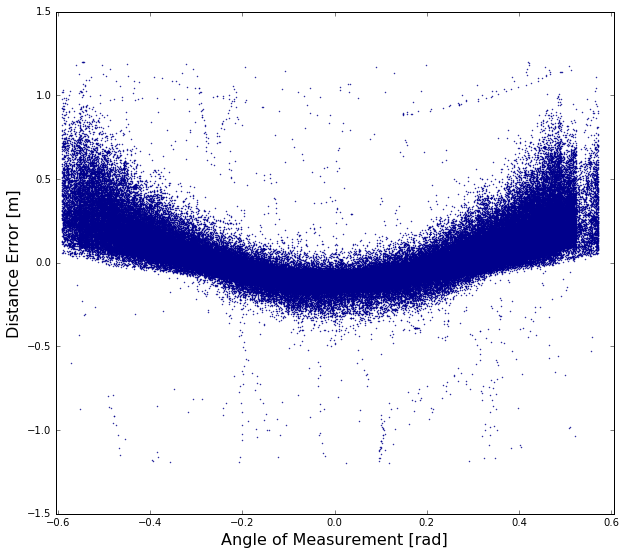

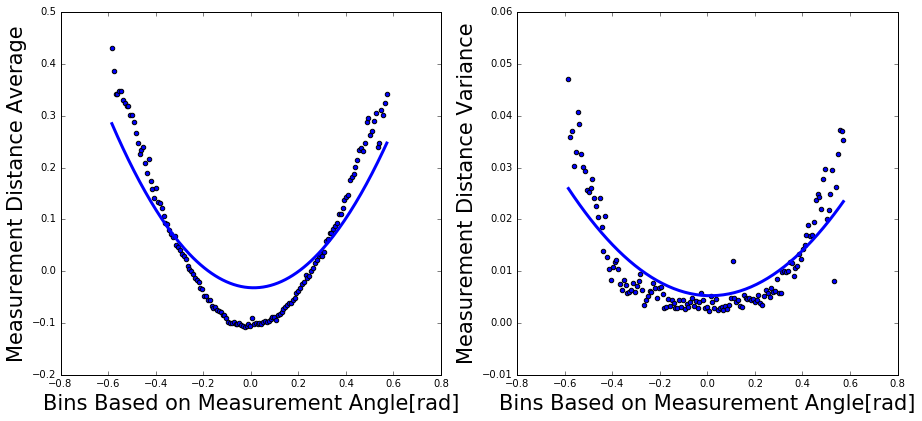

In [14]:
with open('saved_angle_dist_sepR.bins','rb') as f:
    (angleError,distErr)=pickle.load(f)
    
plt.figure(figsize=(10,9))
#     plt.subplot(211)
#plt.title("Distance error based on measurement angle,\n for all robots in the experiment")
angleErrorAll=np.concatenate([i for ind,i in enumerate(angleError)
                              if ind not in [13,33,38,35,36] 
                            ],axis=0)
distErrAll=np.concatenate([i for ind,i in enumerate(distErr) 
                           if ind not in [13,33,38,35,36]
                          ],axis=0)
print('all variances',np.var(angleErrorAll[:,1:],axis=0),
      np.var(distErrAll[:,1:],axis=0))




indsAng=np.abs(angleErrorAll[:,1])<1.2
startingLen=len(angleErrorAll)
print('start len',len(angleErrorAll))
angleErrorAllp=angleErrorAll[indsAng]
print('end len',startingLen/len(angleErrorAll)-1)

#print('angle err',sum(indsAng),angleError.shape)

varDistanceAll=np.var(angleErrorAll[:,1:],axis=0)

print('now var dist',varDistanceAll)

blueD=(0,0,140/255)

plt.scatter(angleErrorAllp[:,0],angleErrorAllp[:,1],c=blueD,s=0.2,edgecolors=blueD)
plt.xlim(-0.605,0.605)
# plt.hist(angleError[:,1],bins=300)
# plt.figure(figsize=(20,9))
# plt.hist(angleError[:,2],bins=300)
indsDist=np.abs(distErrAll[:,1])<1.5
distErr=distErrAll[indsDist]
#plt.scatter(distErr[:,0],distErr[:,1],c='b')
# plt.tick_params(labelsize=14)
plt.xlabel("Angle of Measurement [rad]", fontsize=16)
plt.ylabel("Distance Error [m]", fontsize=16)
plt.savefig("meas_error_all_print.png",dpi=320)


binAcount=150
binARes=makeBins(angleErrorAllp,binAcount,1)
dobinDist=True

if  dobinDist:
    print("percentile length inside bin",np.percentile(binARes[:,2],np.linspace(0,100,20)))
    plt.figure(figsize=(25,12))
#     plt.subplot(311)
#     plt.title("Distance error length ")
#     plt.scatter(binARes[:,0],binARes[:,2])
    fontSize=21
    tickFont=14
    padS=2
    f, (ax2,ax1) = plt.subplots(1,2,figsize=(15,6.5))
    
#     ax1.tick_params(labelsize=tickFont)
#     plt.subplot(211)
#     plt.title("Distance Error Var")
    ax1.scatter(binARes[:,0],binARes[:,1])
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    ax1.plot(binARes[:,0], binARes[:,4], color='blue',
             linewidth=3)
    ax1.set_xlabel("Bins Based on Measurement Angle[rad]",fontsize=fontSize)
    ax1.set_ylabel("Measurement Distance Variance",fontsize=fontSize)
#     plt.subplot(221)
#     plt.title("Distance Error Average")
#     ax2.tick_params(labelsize=tickFont)
    ax2.scatter(binARes[:,0],binARes[:,3])
    ax2.set_xlabel("Bins Based on Measurement Angle[rad]",fontsize=fontSize)
    ax2.set_ylabel("Measurement Distance Average",fontsize=fontSize)
    
    print('model shapes',binARes[:,0].reshape(-1,1).shape, binARes[:,3].shape)
#     model = make_pipeline(PolynomialFeatures(2), Ridge())
#     svrRes=model.fit(binARes[:,0].reshape(-1,1), binARes[:,3]).predict(binARes[:,0].reshape(-1,1))
#     plt.plot(binARes[:,0], svrRes, color='blue',
#              linewidth=3)
# !!!!!!!!!!!!!!

    ax2.plot(binARes[:,0], binARes[:,5], color='blue',
             linewidth=3)
   
    plt.savefig("parabola_estimate_print.png",dpi=320)
    
# dBin=binTable(alternate=varDistanceAll[0])
dBin=binTable(table=binARes)

aBin=binTable(alternate= varDistanceAll[1])   # 0.00015657)

print('var distance',varDistanceAll)
# print('angle erroor alterantive',np.var(angleError[:,2]),np.var(distErr[:,2]))

# print('distance erroor alterantive',np.var(distErr[:,1]),np.var(angleError[:,1]))
# print(binARes[:5])
# print(dBin.getNoise(87650),dBin.getNoise(-460))



In [8]:
aBinName,dBinName='bins/angle.bins_parab_noEx','bins/distance.bins_parab_noEx'
toSaveBin=False
if toSaveBin:
    with open(aBinName,'wb') as f:
        pickle.dump(aBin,f)
    with open(dBinName,'wb') as f:
        pickle.dump(dBin,f)
    print('Done !')

Done !


In [78]:
with open('saved_angle_dist_sepR.bins','rb') as f:
    (angleError,distErr)=pickle.load(f)
    
angleErrDat,distErrDat,varDistanceDat={i:[] for i in range(1,9)}, \
{i:[] for i in range(1,9)},{i:[] for i in range(1,9)}

for ind in range(0,40,5):
    angleErrDat[(ind//5)+1]=np.concatenate(
        [i for inInd,i in enumerate(angleError[ind:ind+5]) 
         if inInd+ind not in [13,33,38,35,36] ],axis=0)
    
    
    distErrDat[(ind//5)+1]=np.concatenate(
        [i for inInd,i in enumerate(distErr[ind:ind+5]) 
         if inInd+ind not in [13,33,38,35,36] ],axis=0)
    varDistanceDat[(ind//5)+1]=np.var(angleErrDat[(ind//5)+1][:,1:],axis=0)

40
percentile length inside bin [  60.          206.42105263  222.          276.          297.94736842
  325.78947368  361.57894737  384.68421053  395.84210526  415.68421053
  424.          430.94736842  446.78947368  459.73684211  490.94736842
  495.73684211  518.47368421  556.31578947  652.          975.        ]
percentile length inside bin [ 170.          246.84210526  370.36842105  399.57894737  436.10526316
  473.10526316  558.21052632  618.          631.84210526  648.84210526
  681.57894737  718.47368421  725.26315789  731.36842105  747.94736842
  781.89473684  793.          804.73684211  840.89473684  909.        ]
percentile length inside bin [  131.           301.31578947   358.           385.26315789   425.78947368
   448.36842105   479.26315789   525.36842105   562.73684211   573.94736842
   582.           584.47368421   600.26315789   618.36842105   637.94736842
   644.           650.68421053   672.94736842   748.52631579  1173.        ]
percentile length inside bin [   99

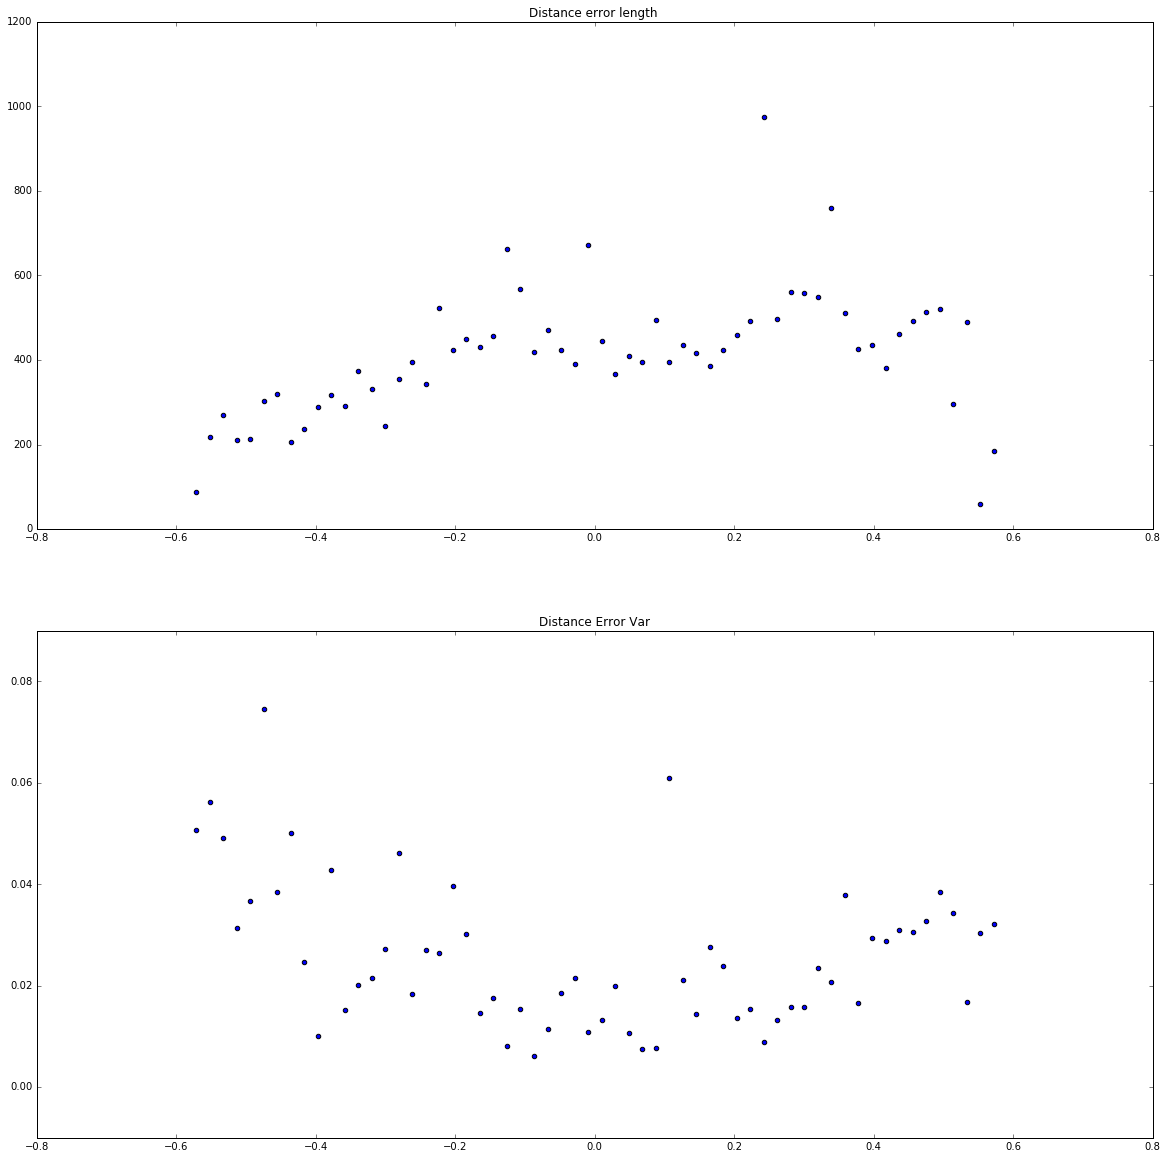

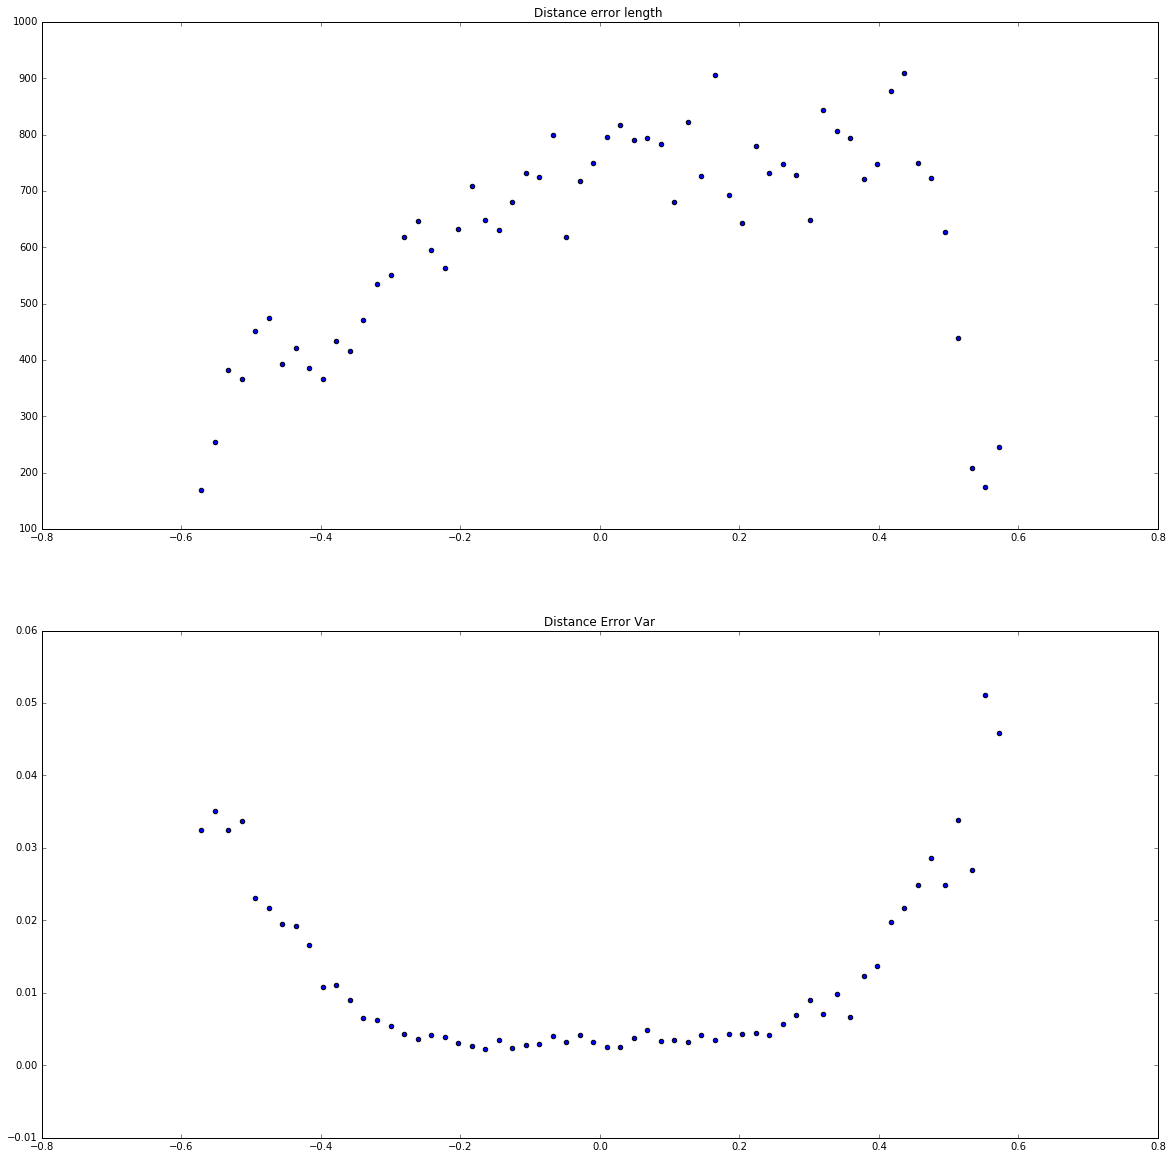

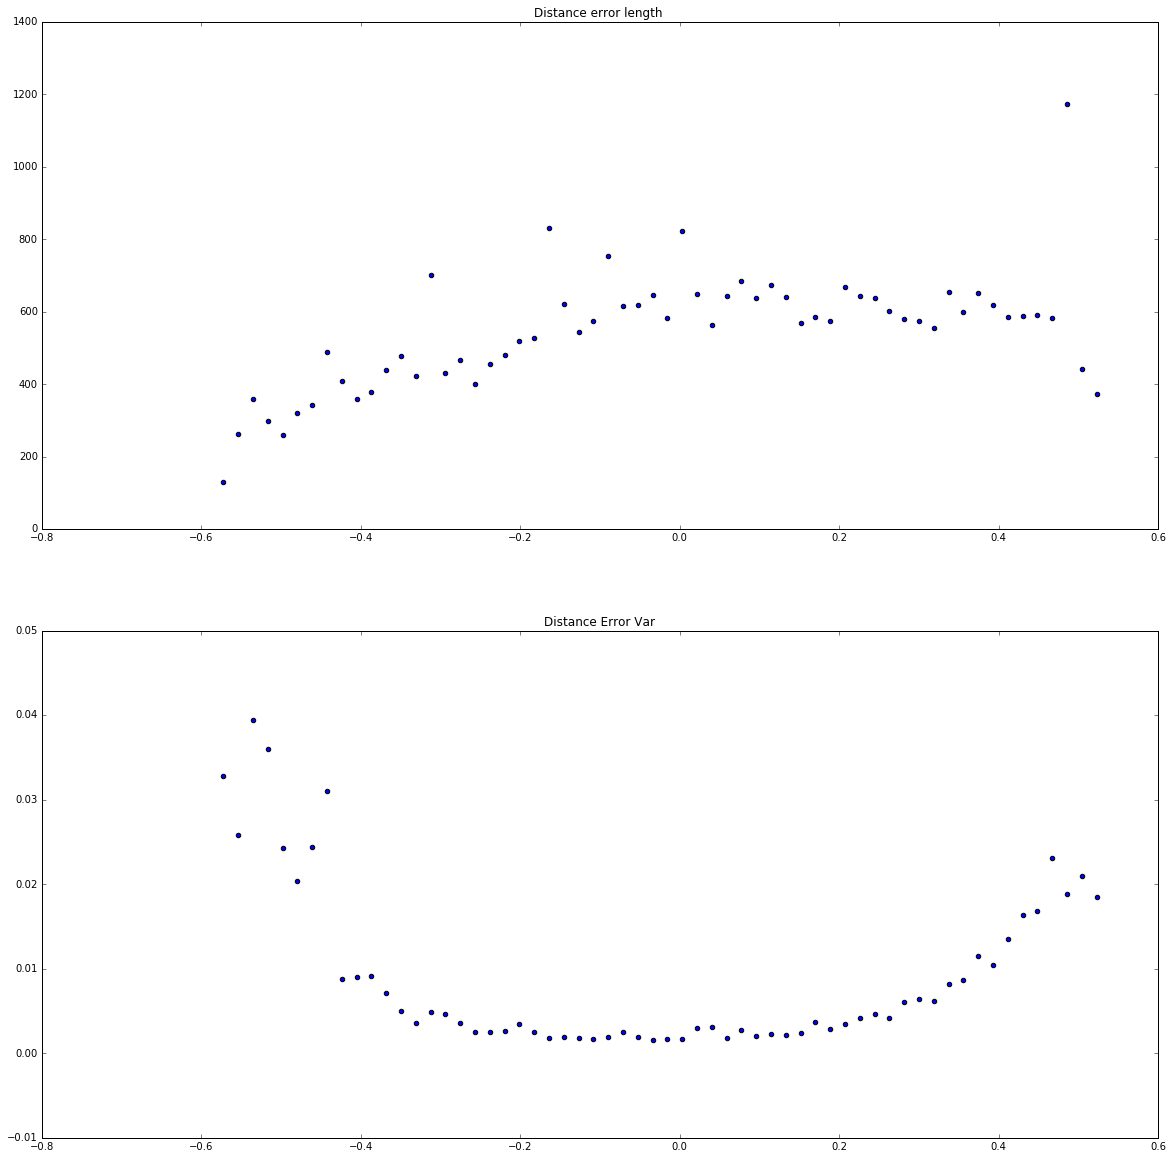

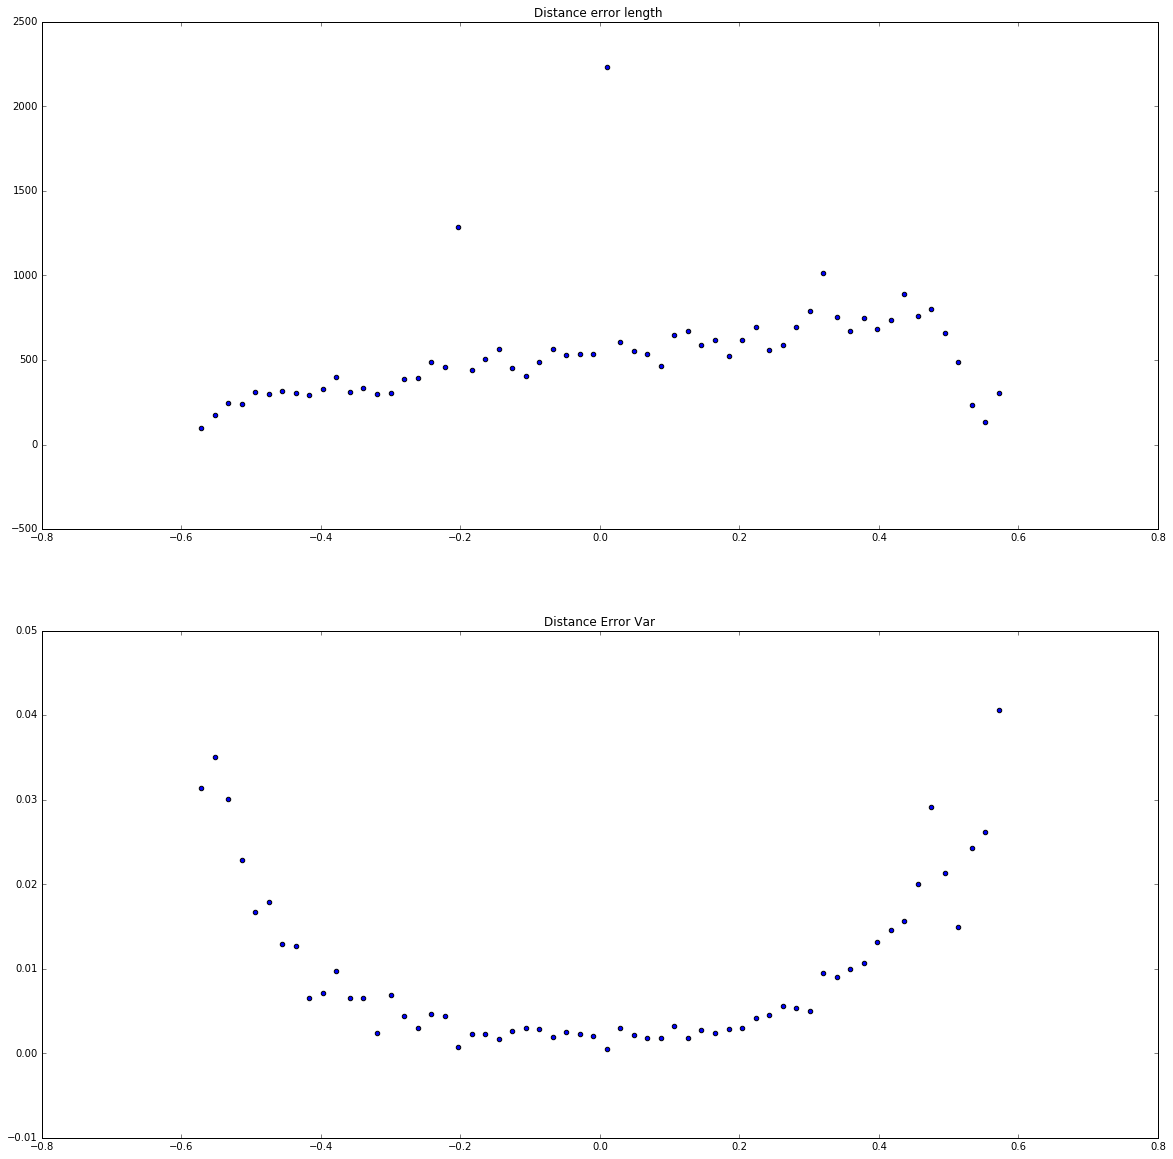

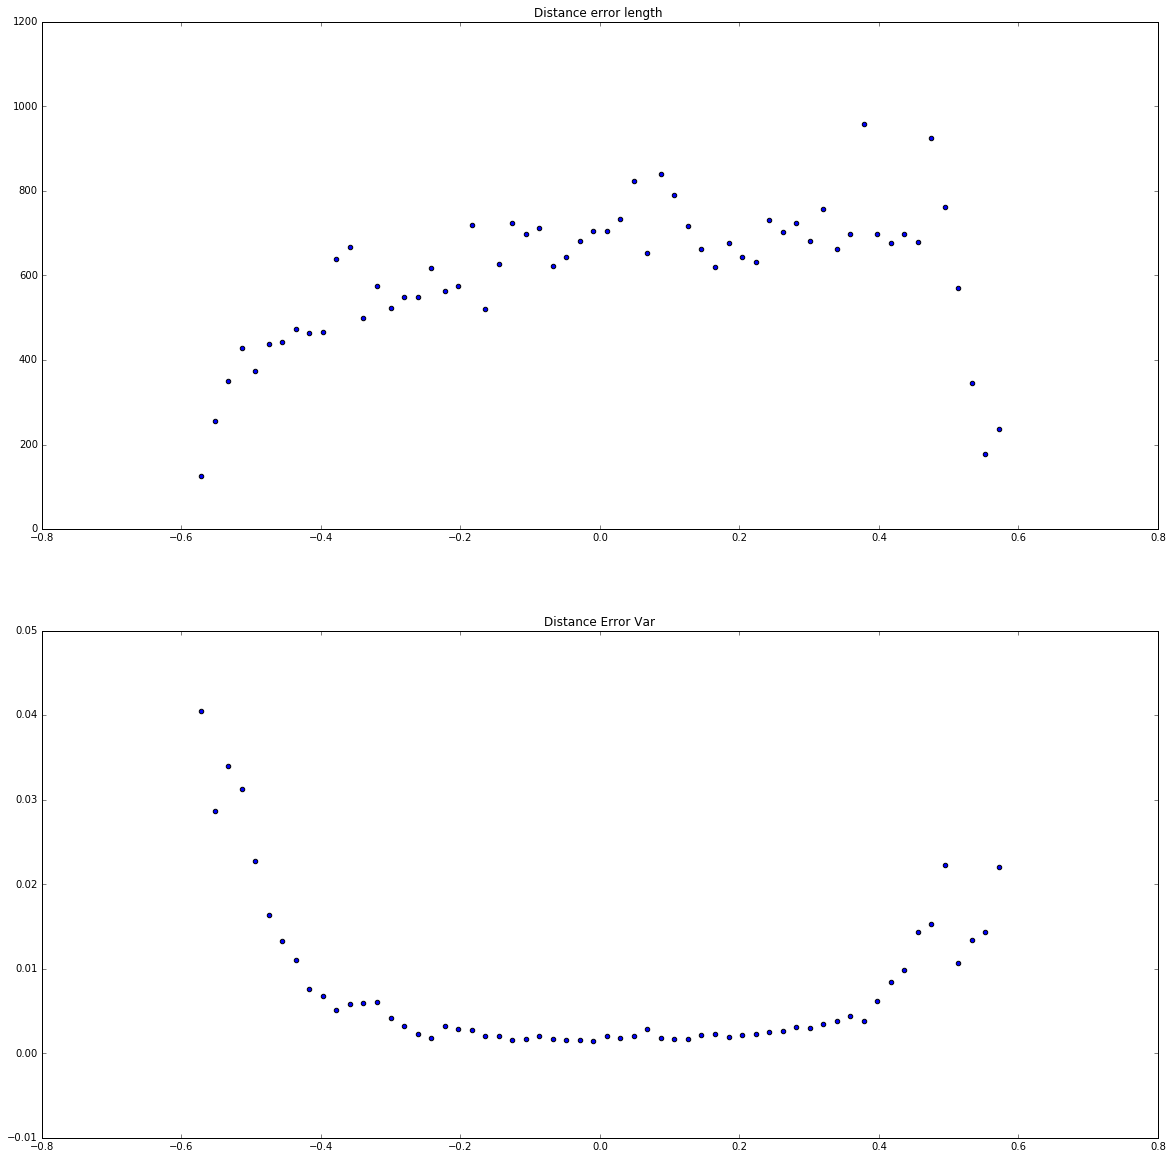

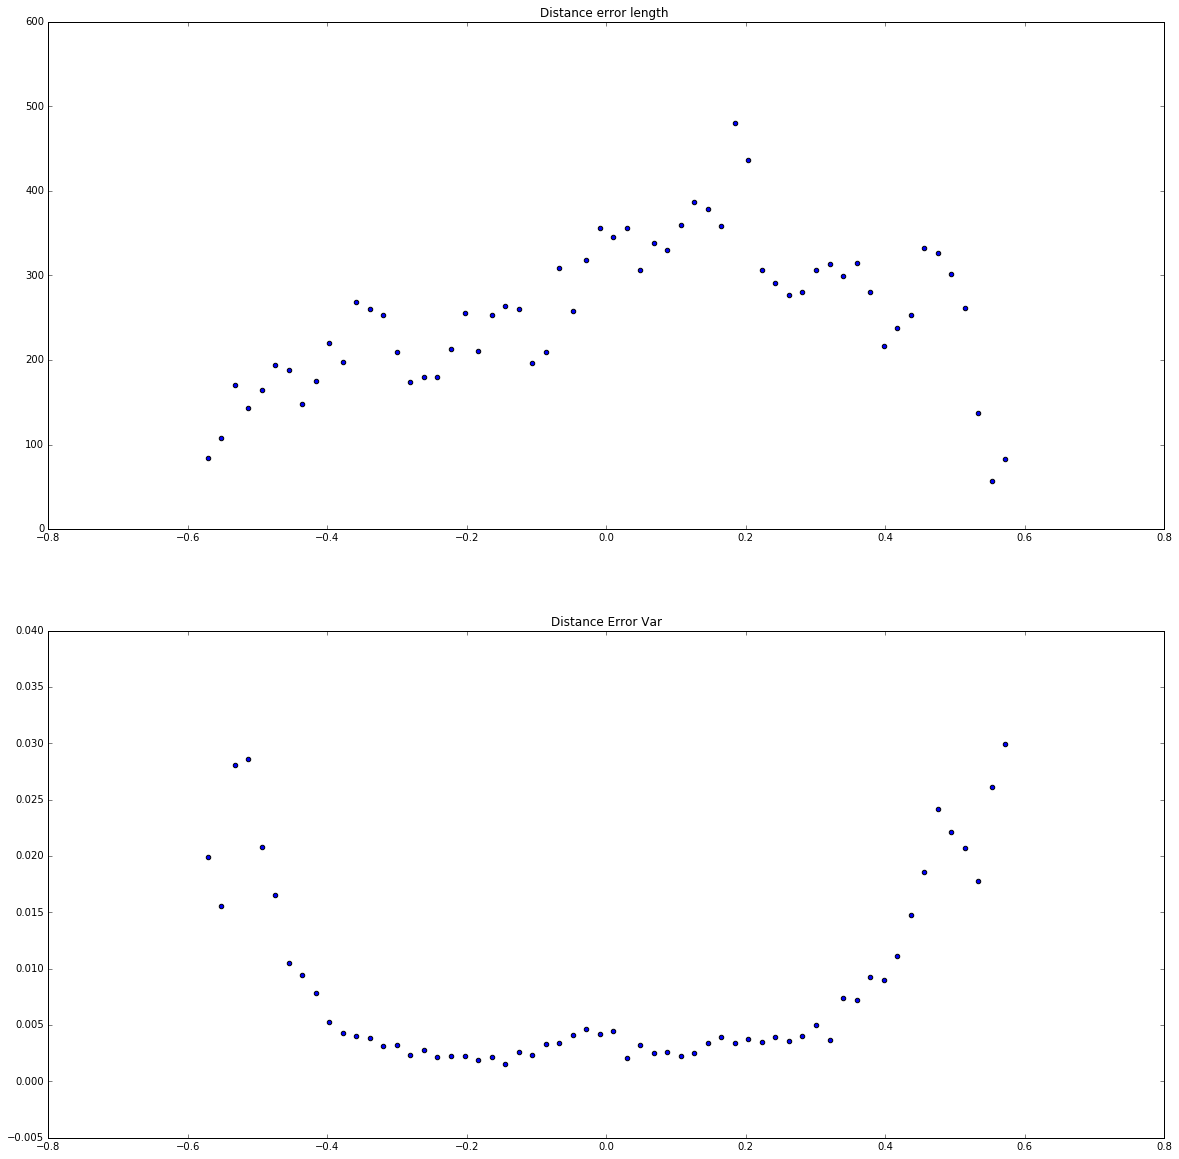

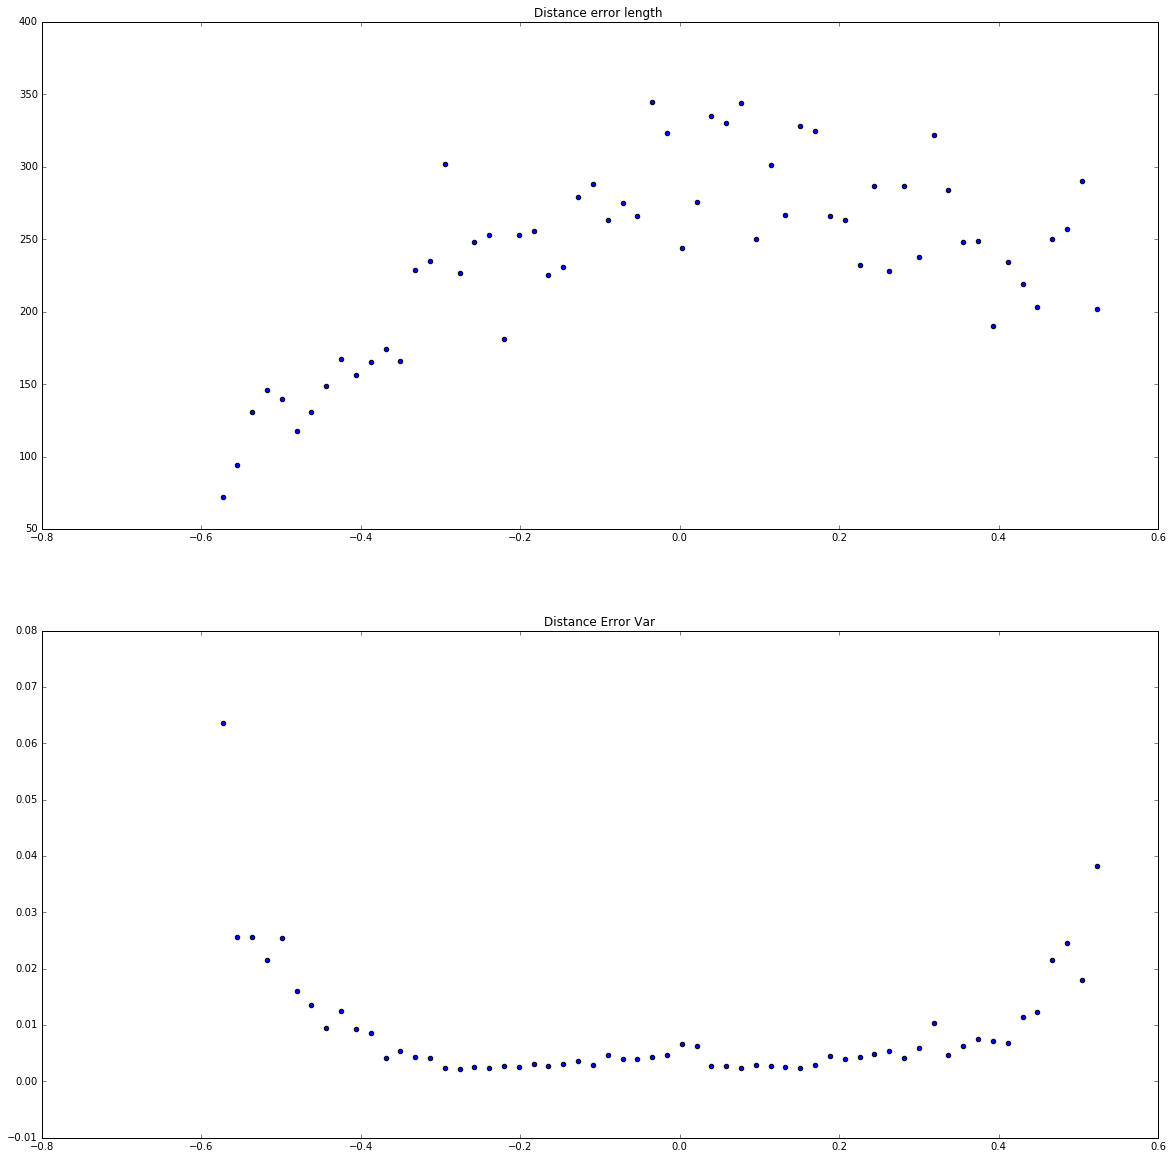

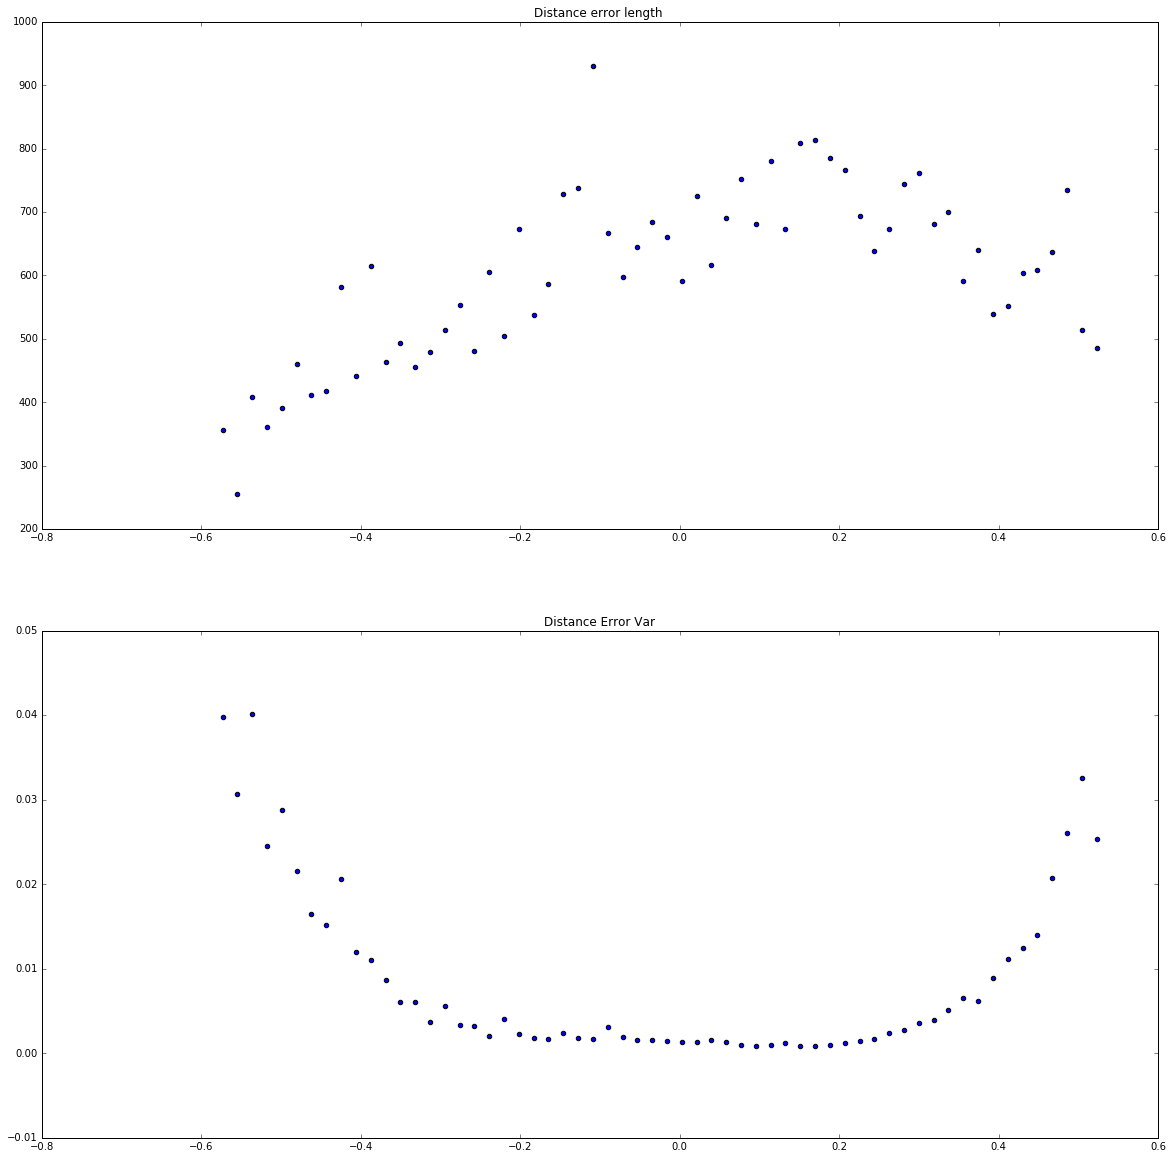

In [87]:
with open('saved_angle_dist_sepR.bins','rb') as f:
    (angleError,distErr)=pickle.load(f)

print(len(angleError))
for ind,aKey in enumerate(angleErrDat):
    angleErr=angleErrDat[aKey]
    indsAng=np.abs(angleErr[:,1])<1.2
    angleErr=angleErr[indsAng]
    
    binAcount=60
    binARes=makeBins(angleErr,binAcount,1)
    dobinDist=True

    if  dobinDist:
        print("percentile length inside bin",np.percentile(binARes[:,2],np.linspace(0,100,20)))
        plt.figure(figsize=(20,20))
        plt.subplot(211)
        plt.title("Distance error length ")
        plt.scatter(binARes[:,0],binARes[:,2])

        plt.subplot(212)
        plt.title("Distance Error Var")
        plt.scatter(binARes[:,0],binARes[:,1])
        
   

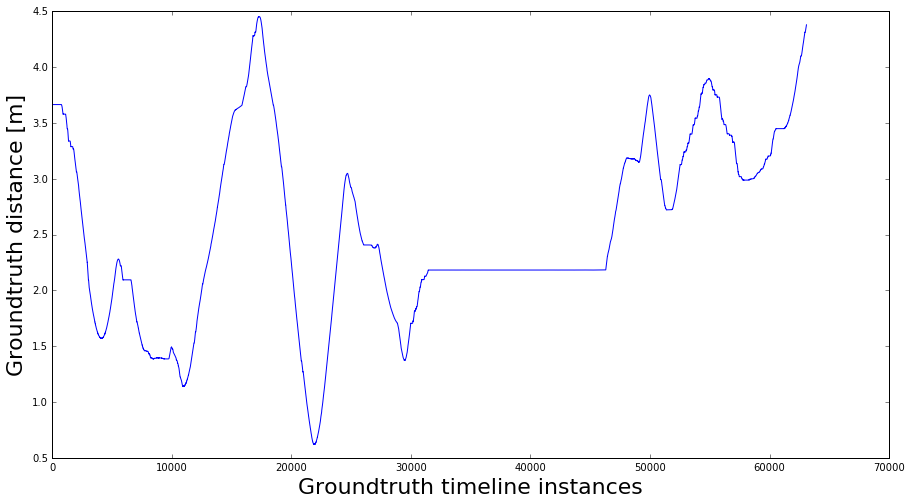

In [5]:
"Plotting for Preprocessing"

plt.figure(figsize=(15,8))

odom,meas,groun,landDik=getAllMulti(7,4)  #(7,4)

# plt.subplot(211)
# plt.title("Robot Groundtruth position as a vector")
plt.ylabel("Groundtruth distance [m]",fontsize=22)
plt.xlabel("Groundtruth timeline instances",fontsize=22)
plt.plot(np.arange(len(groun)),np.sqrt(np.sum(groun[:,1:3]**2,axis=1)) )

odom,meas,groun,landDik=getAllMulti(4,3)

# plt.subplot(212)
# plt.plot(np.arange(len(groun)),np.sqrt(np.sum(groun[:,1:3]**2,axis=1)) )

plt.savefig("bad_robot.png",dpi=220)

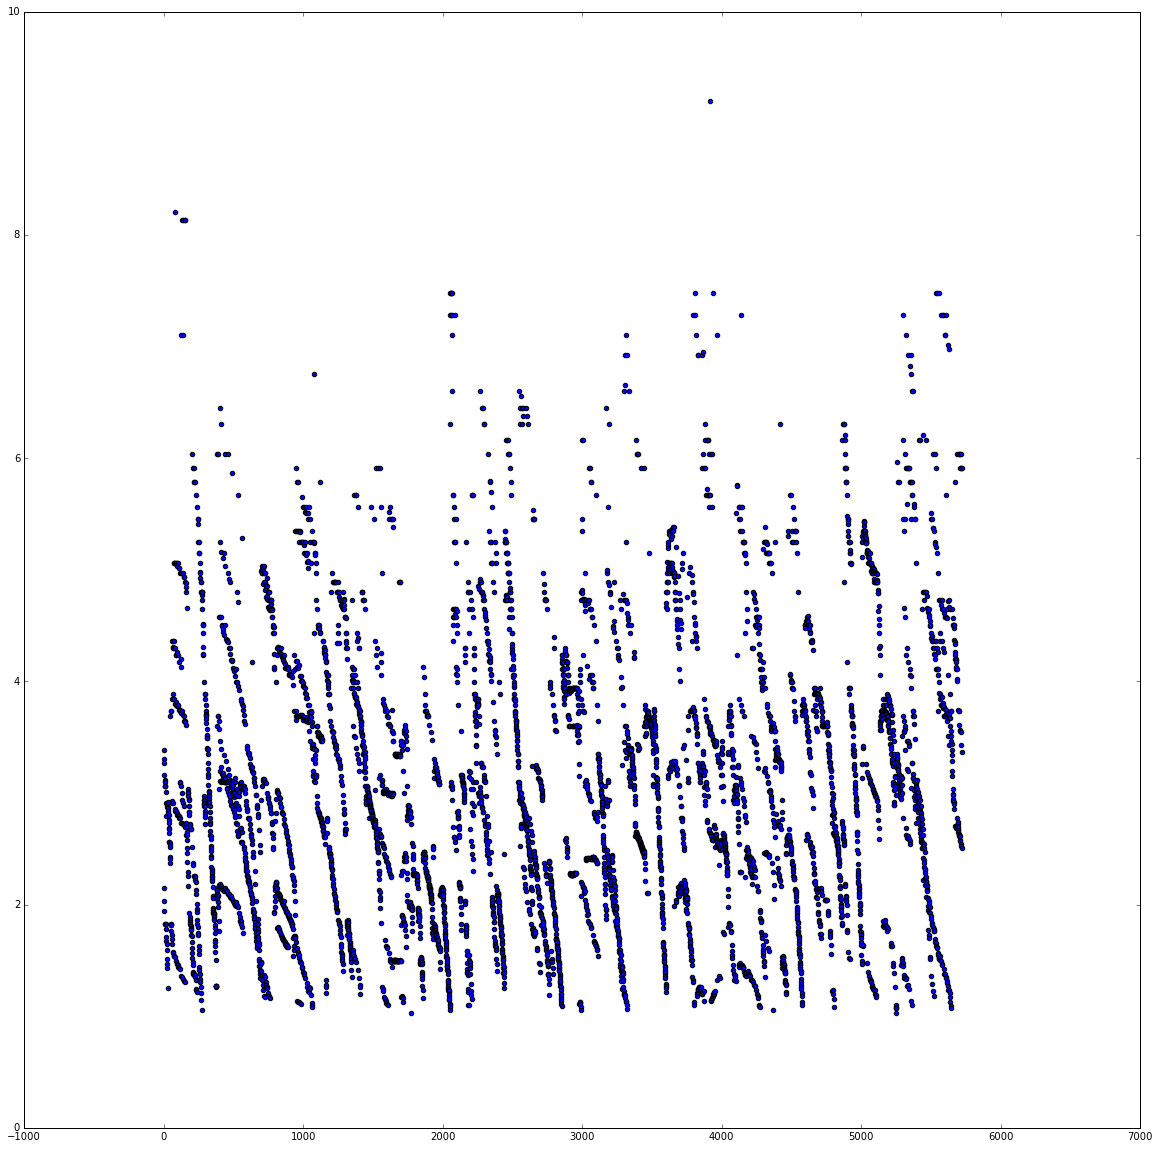

In [35]:
plt.figure(figsize=(20,20))

odom,meas,groun,landDik=getAllMulti(1,1)
plt.scatter(np.arange(len(meas)),meas[:,2])

40
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shape

C:\Users\User\Miniconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes (20, 1) (20,)
bin shapes (20, 1) (20,)
model shapes

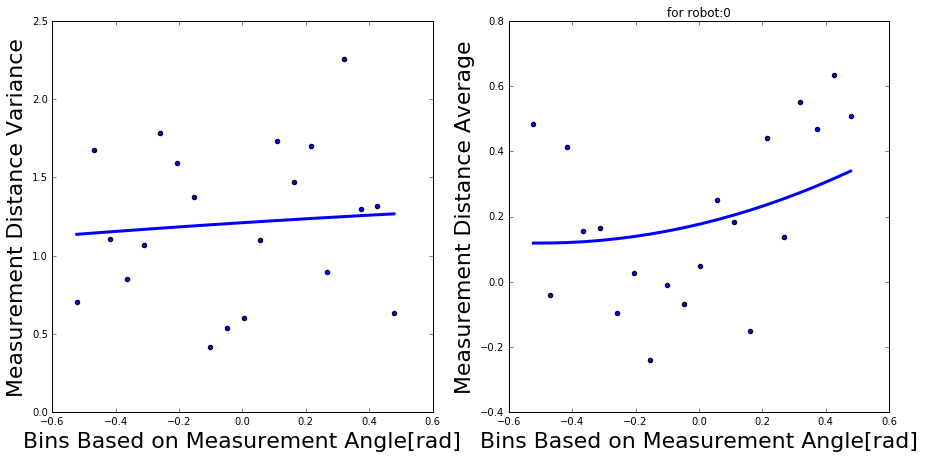

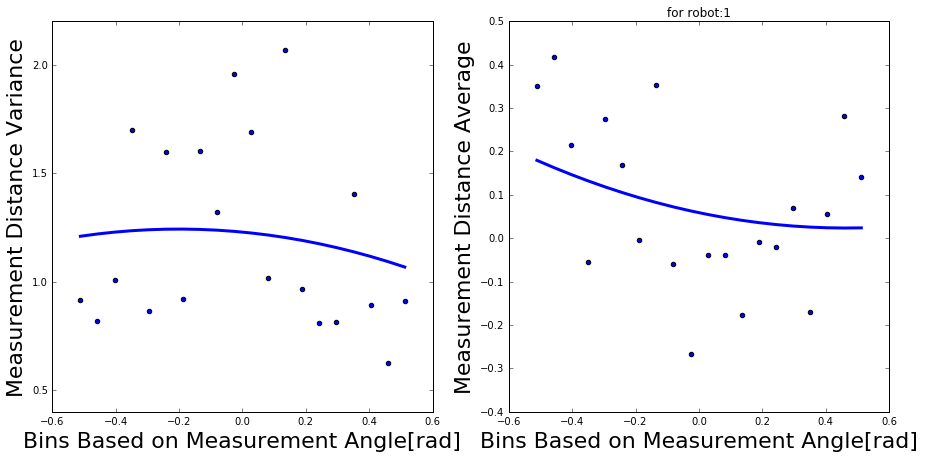

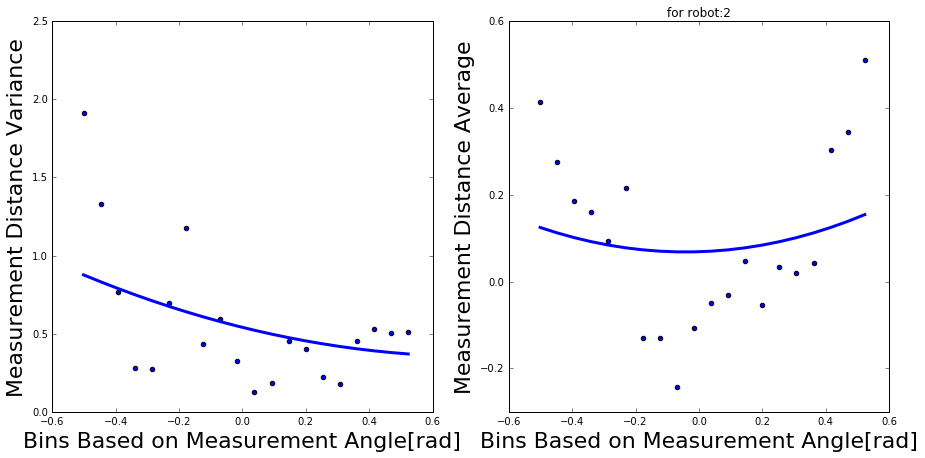

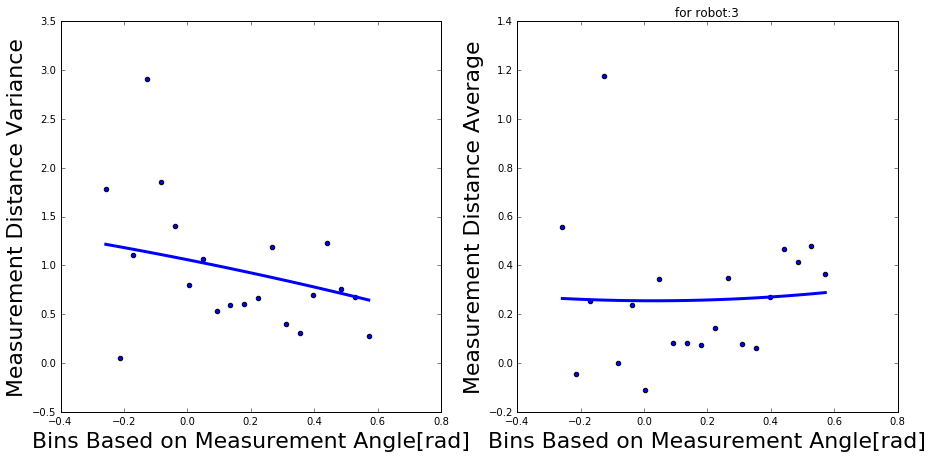

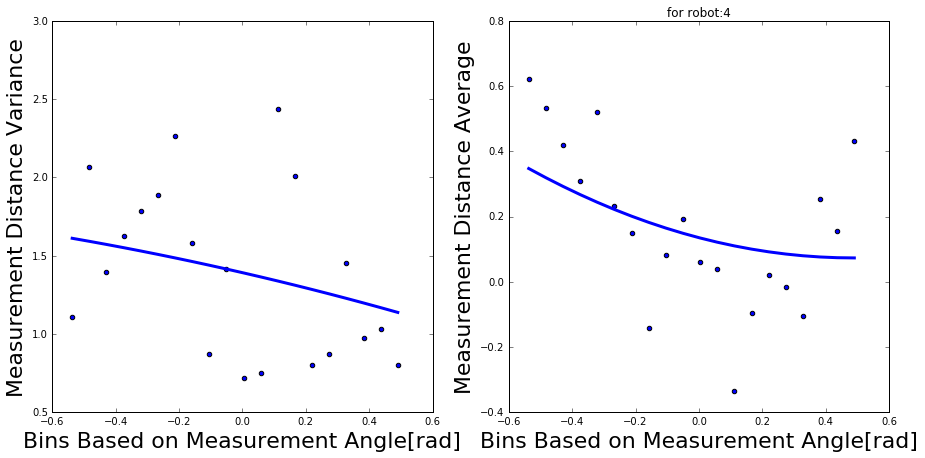

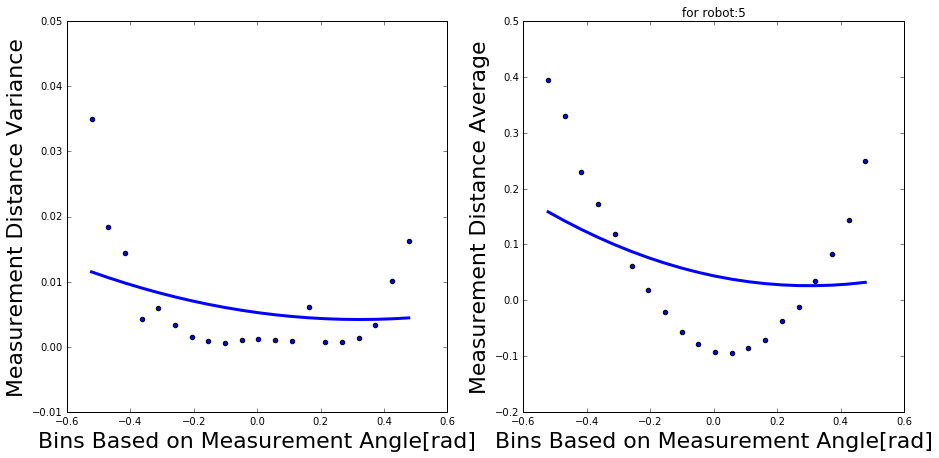

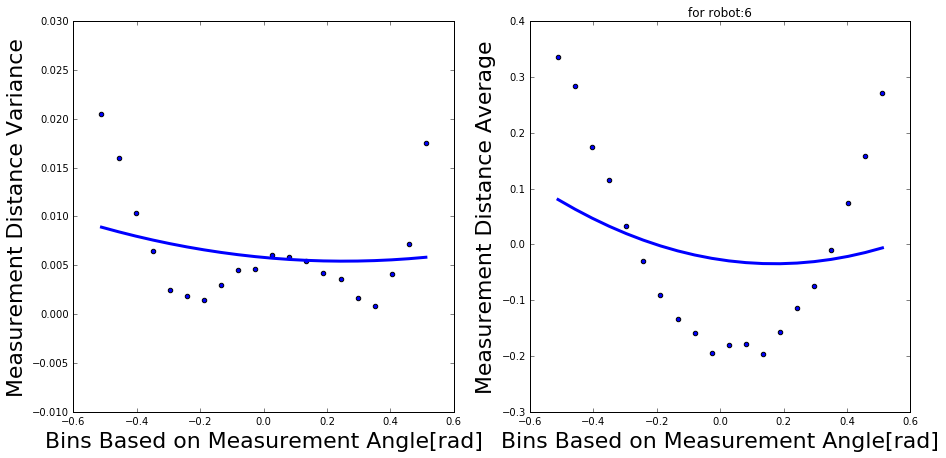

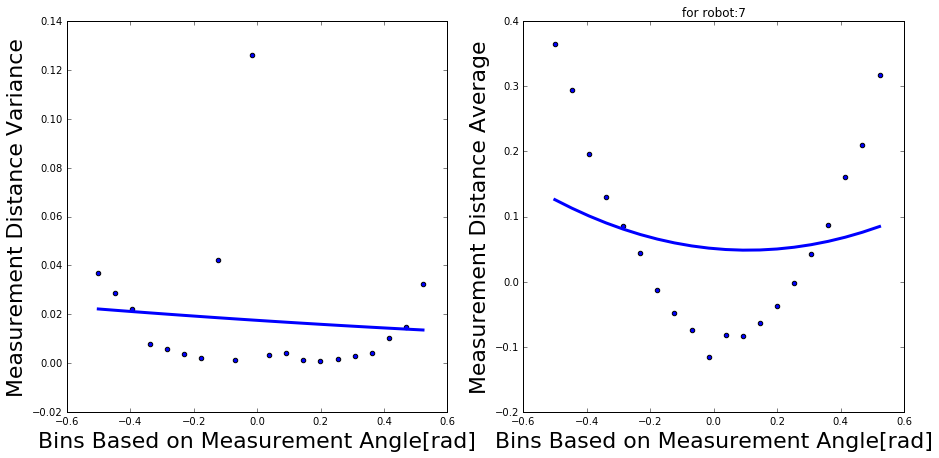

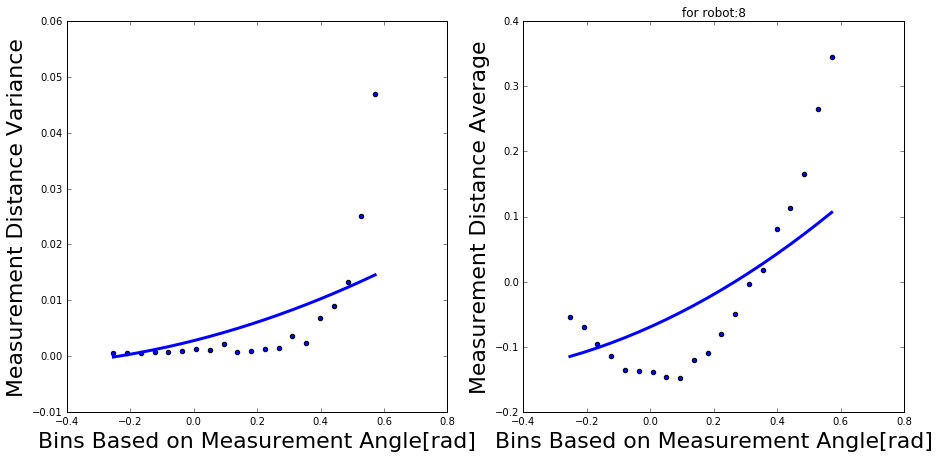

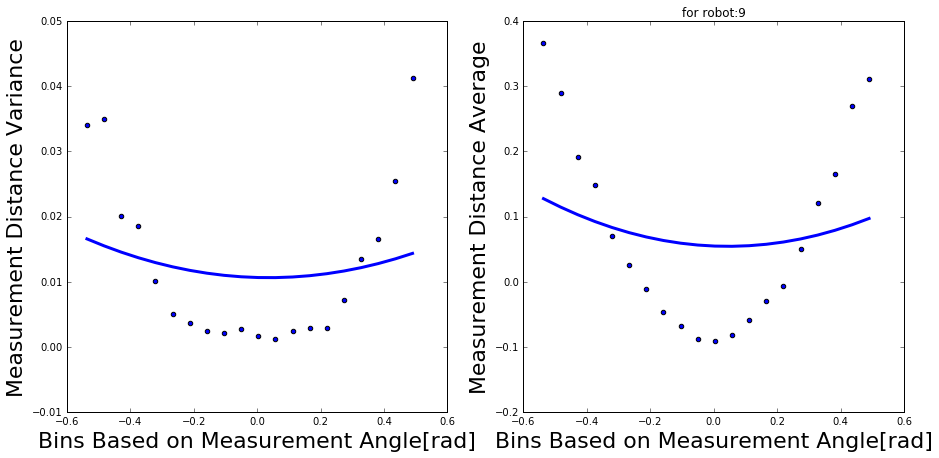

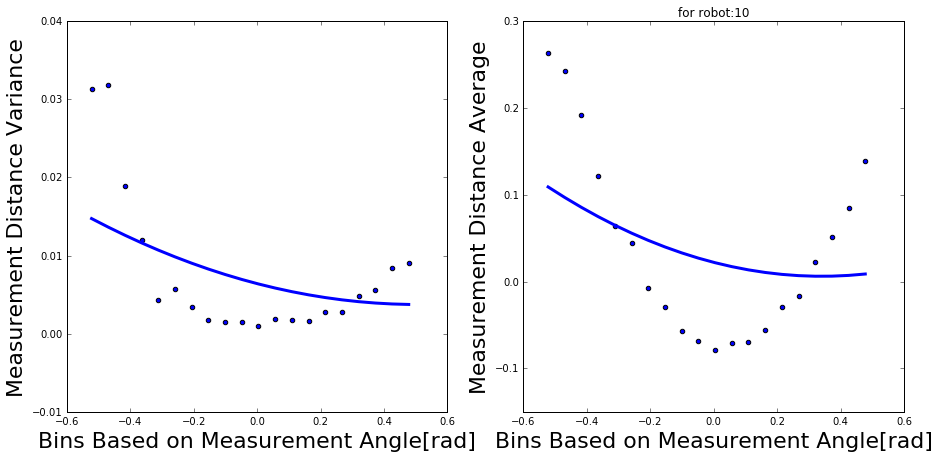

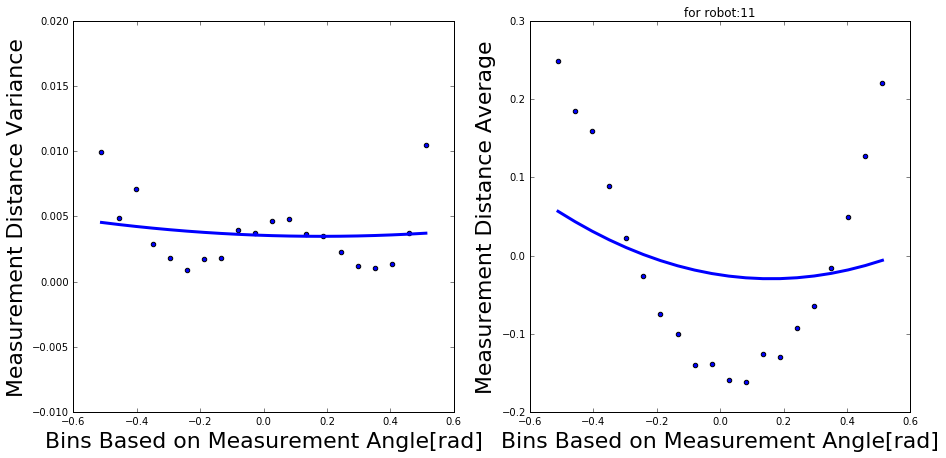

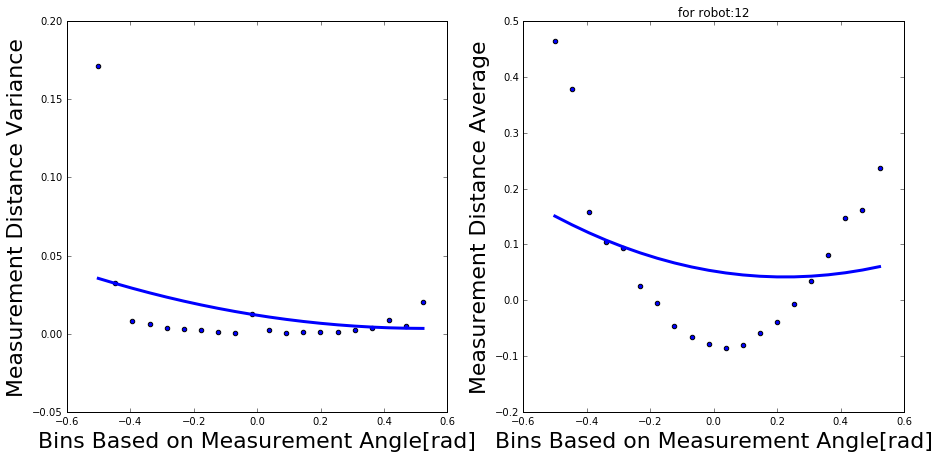

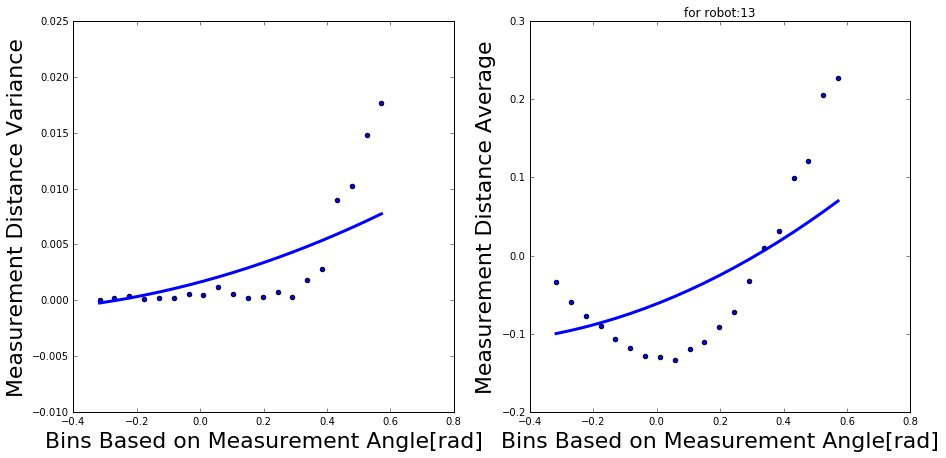

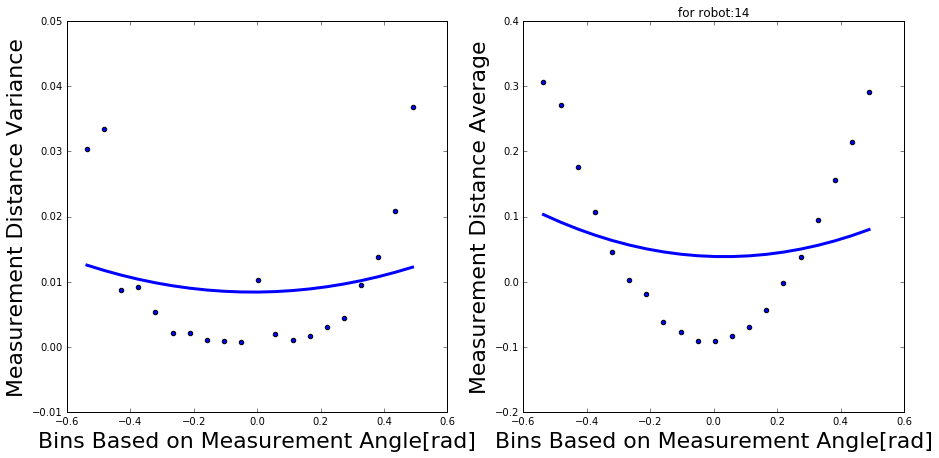

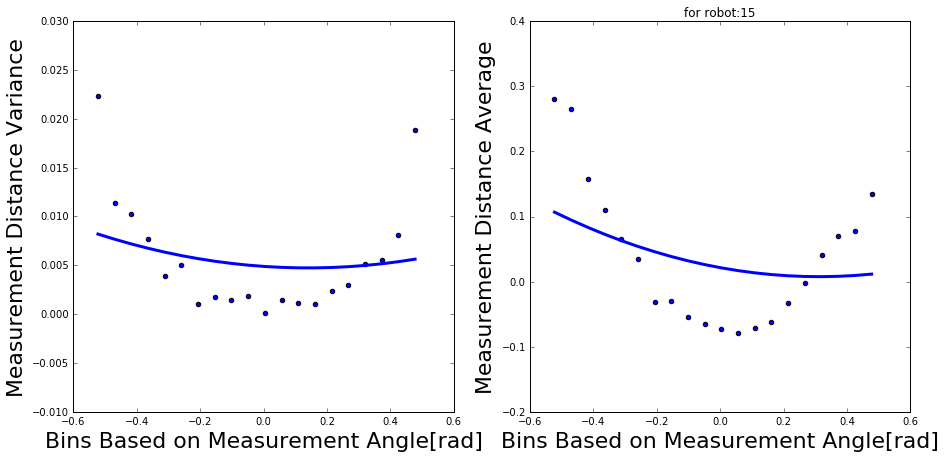

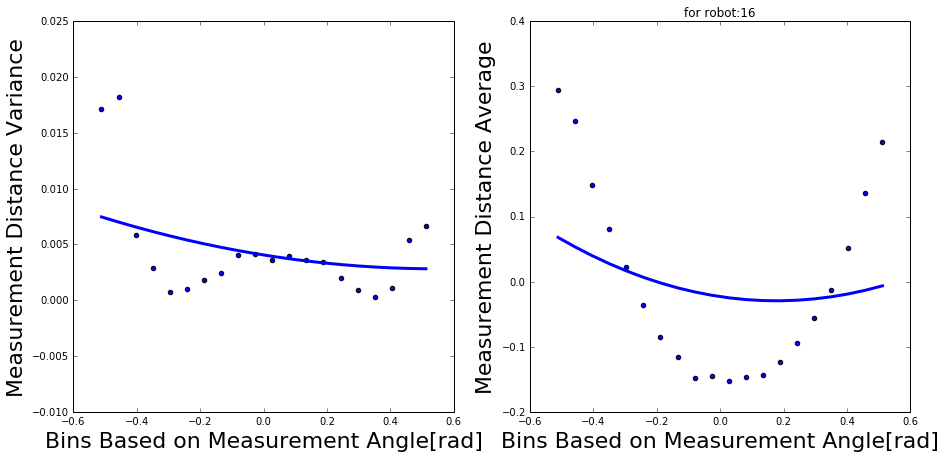

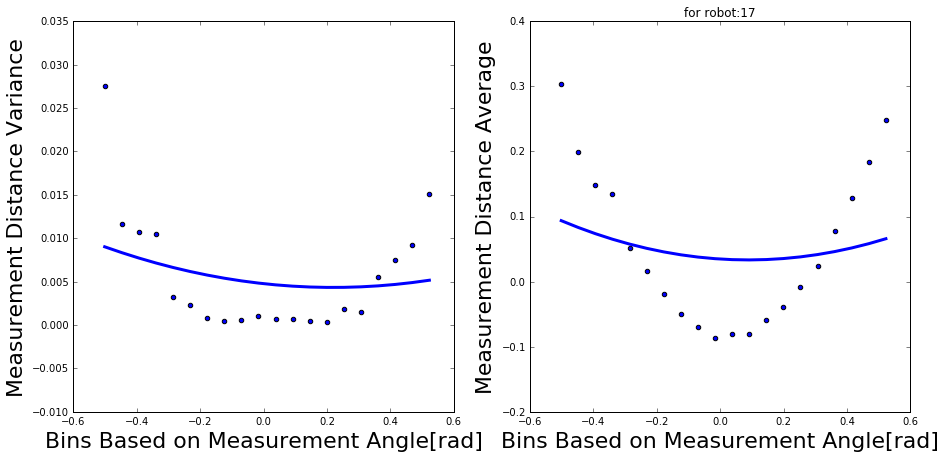

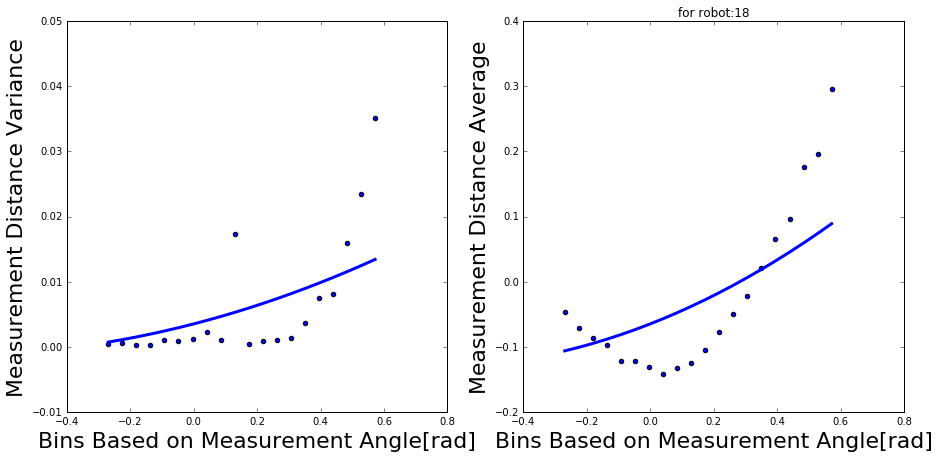

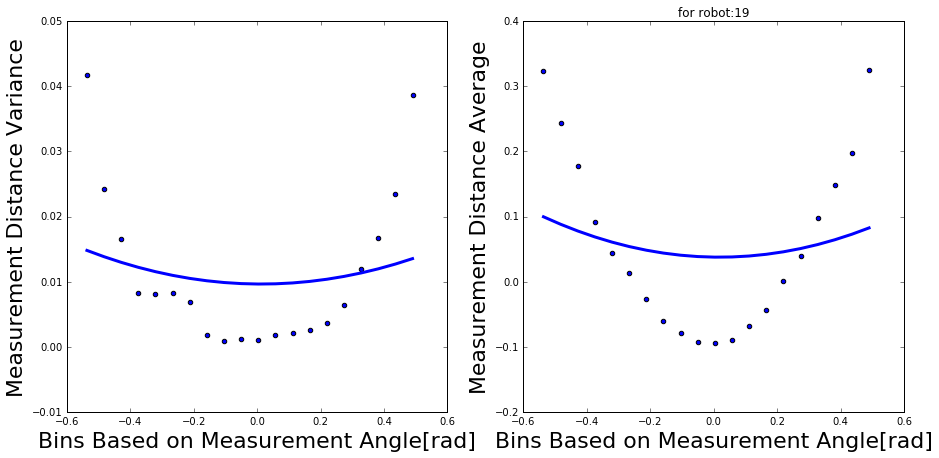

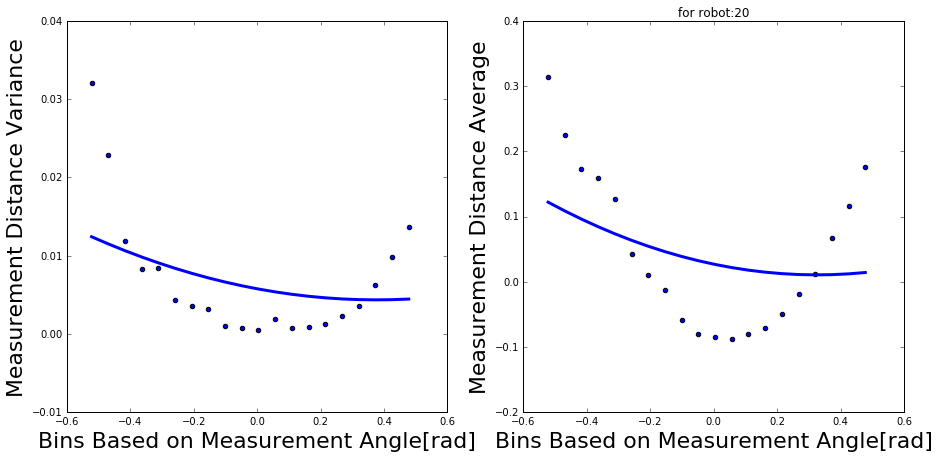

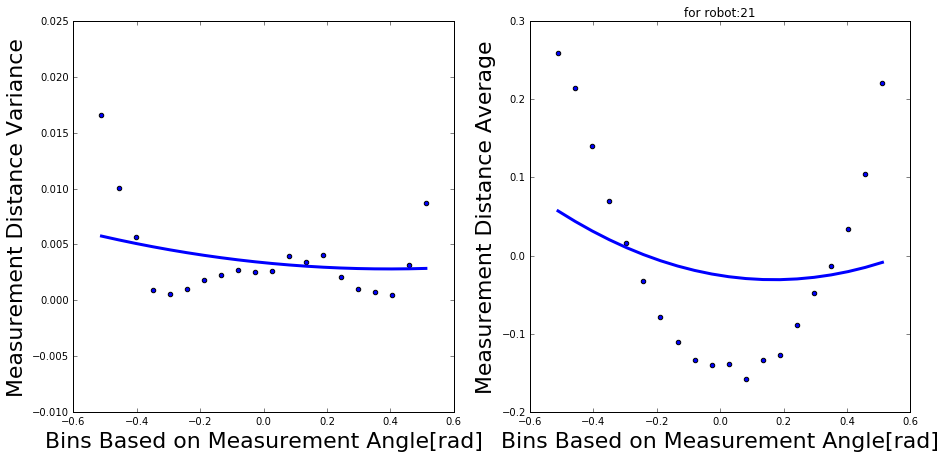

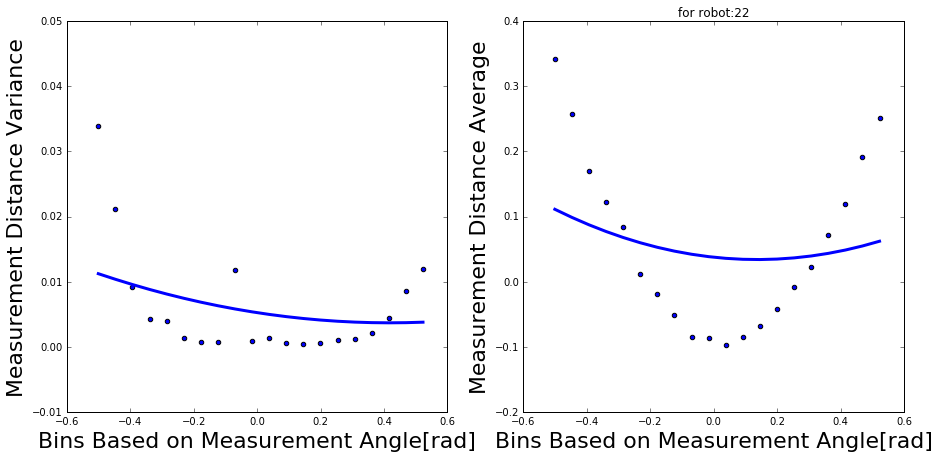

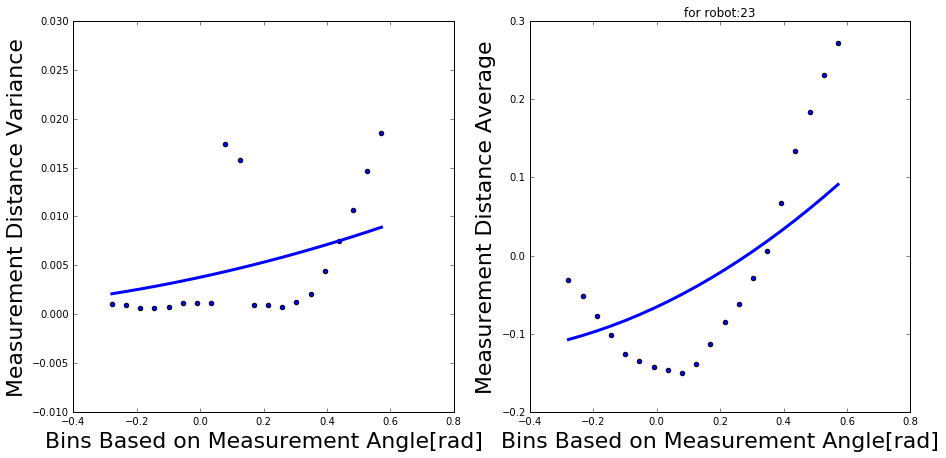

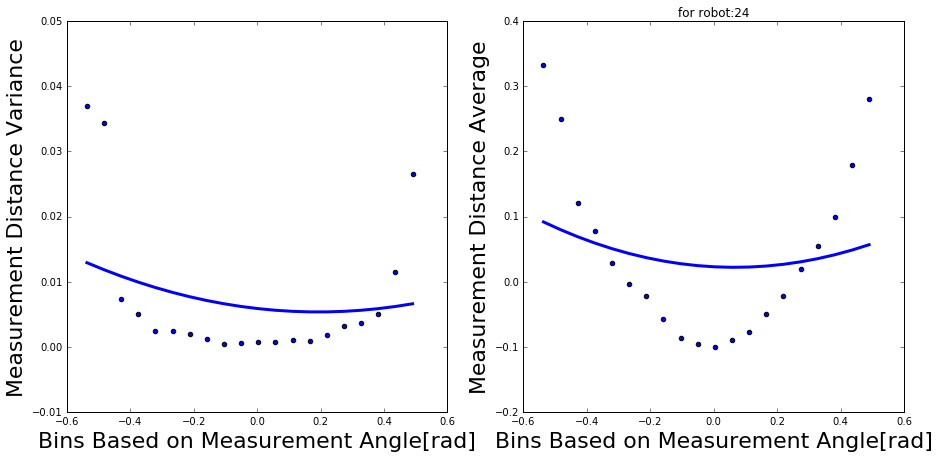

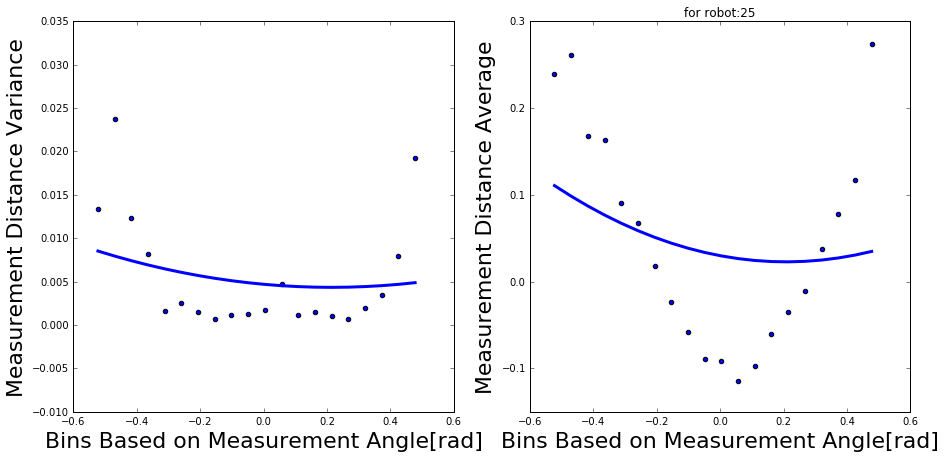

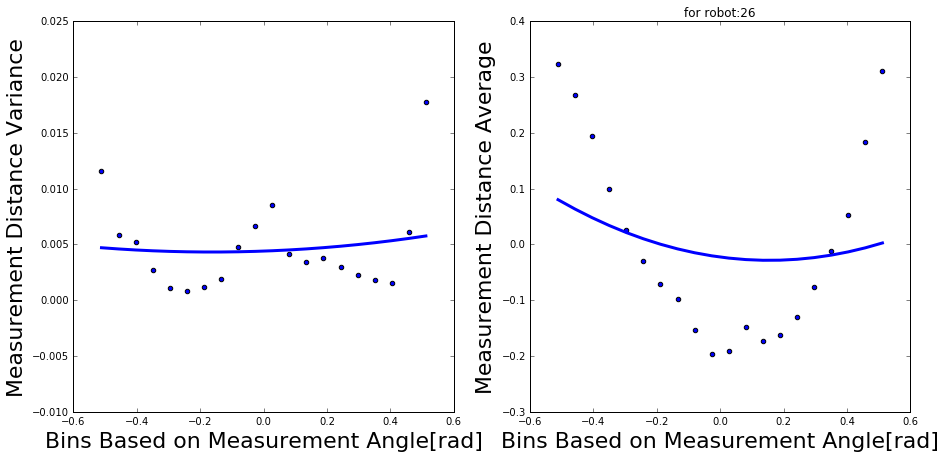

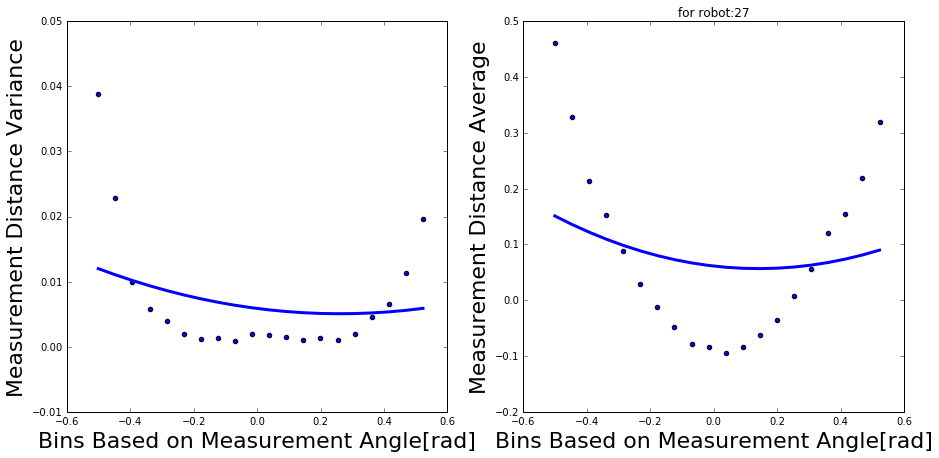

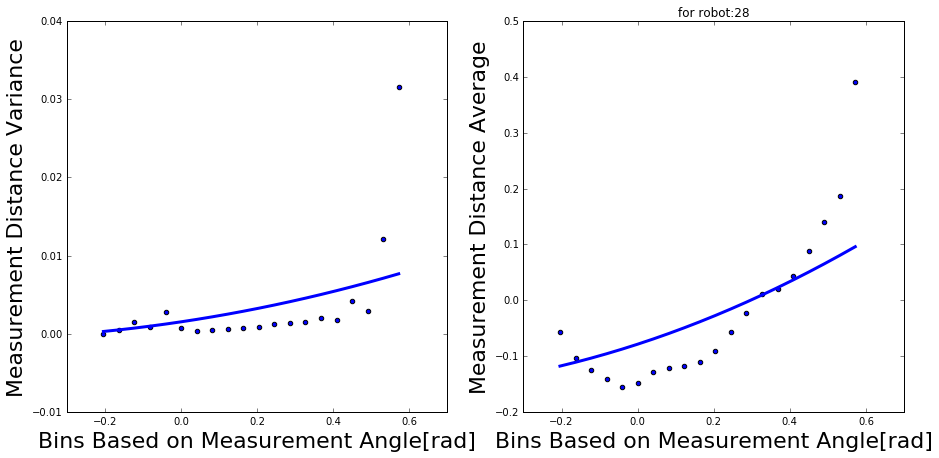

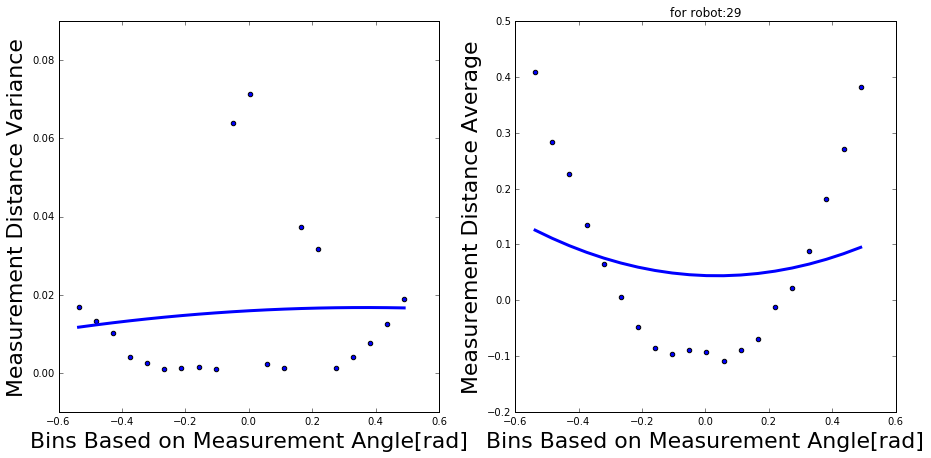

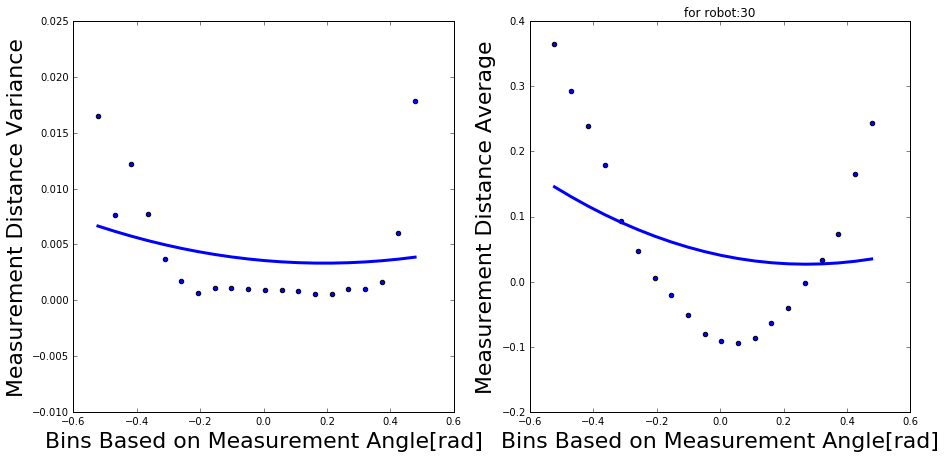

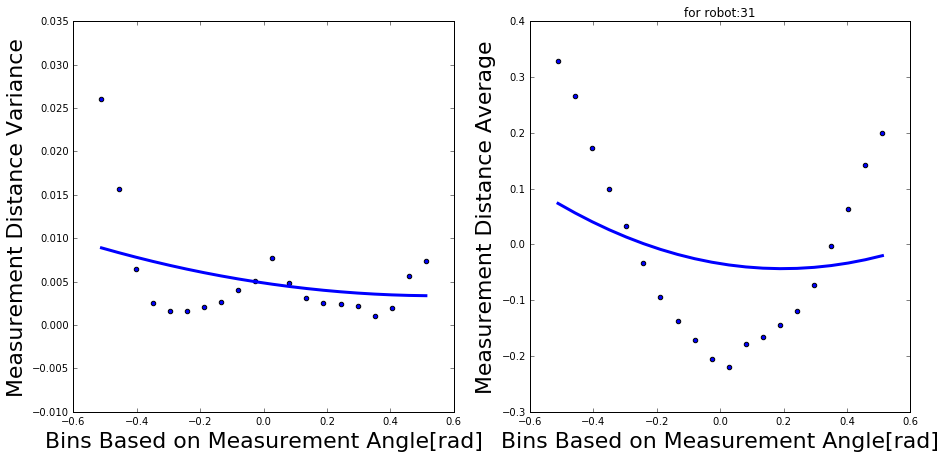

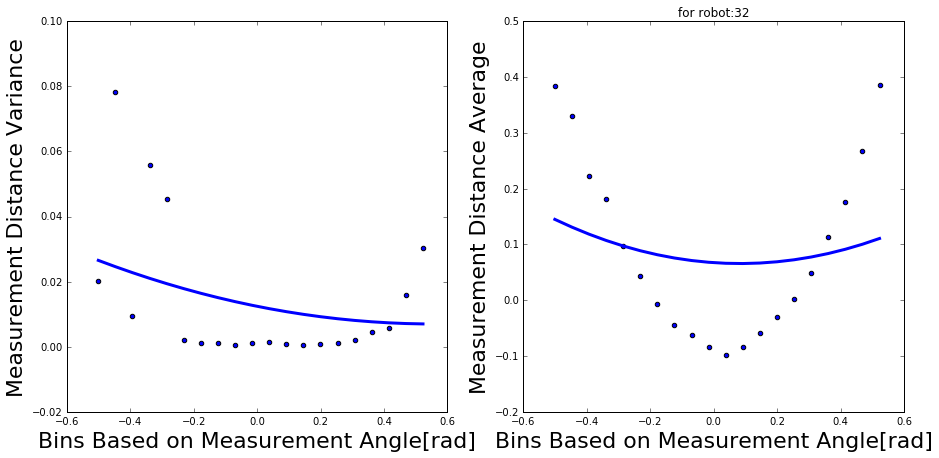

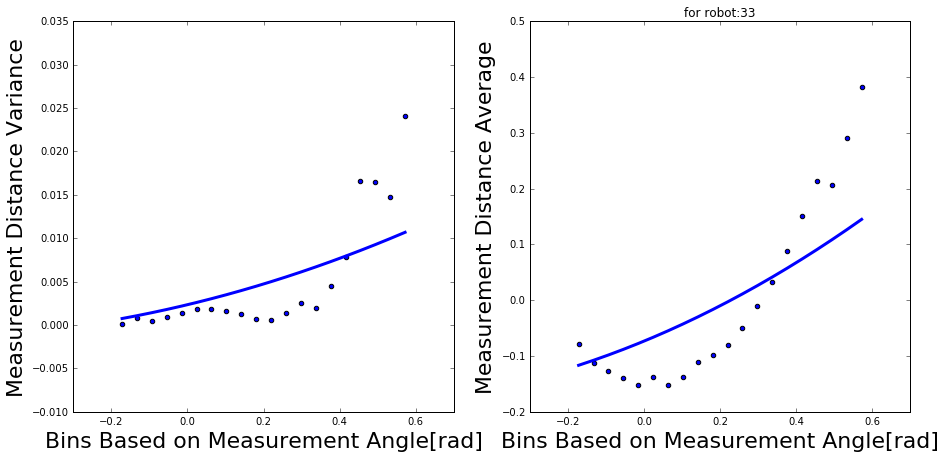

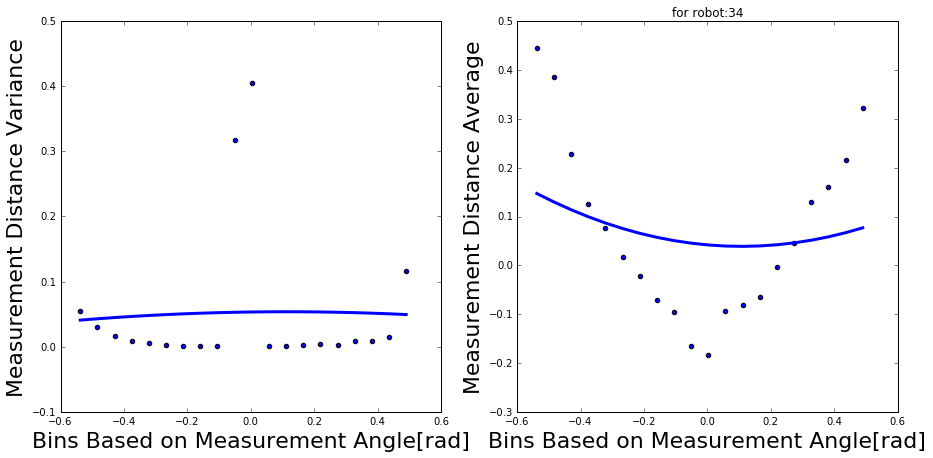

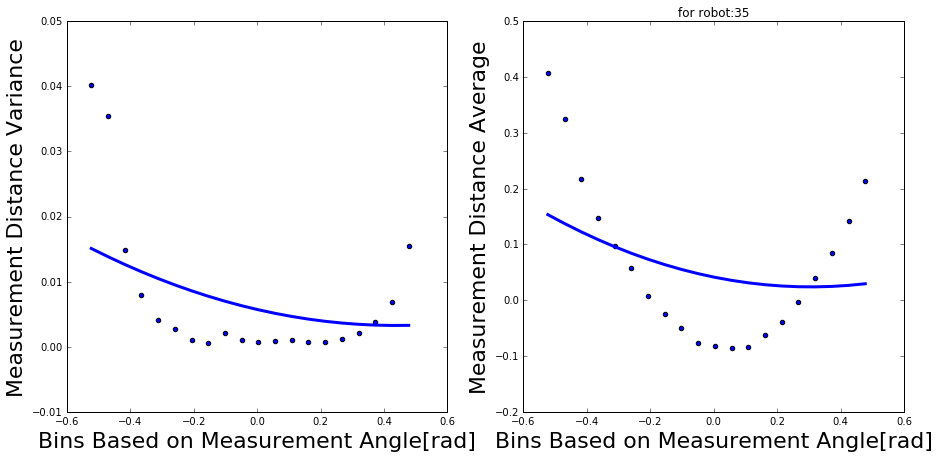

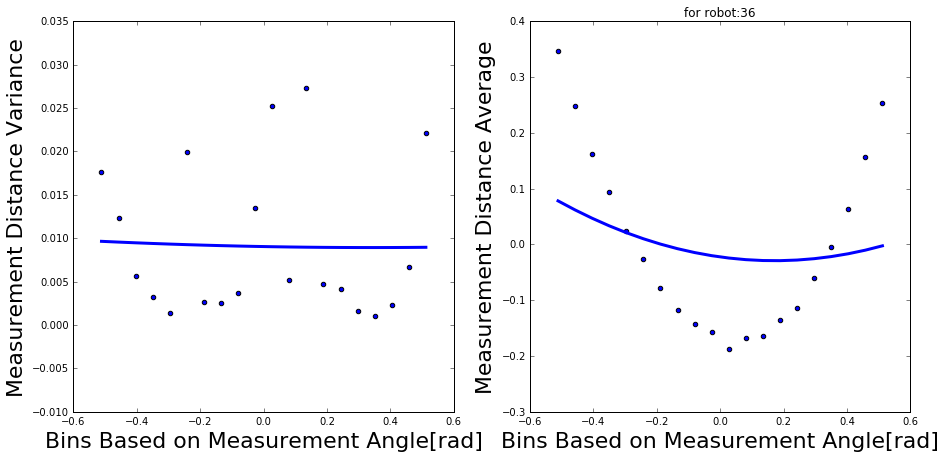

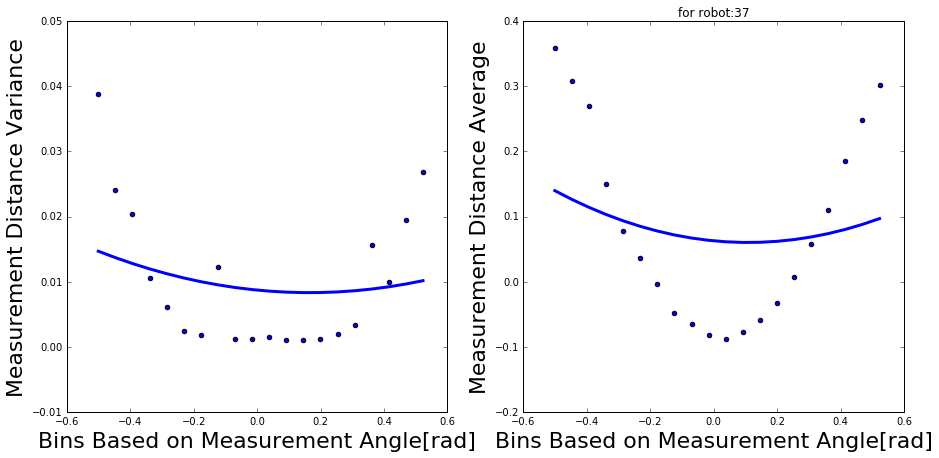

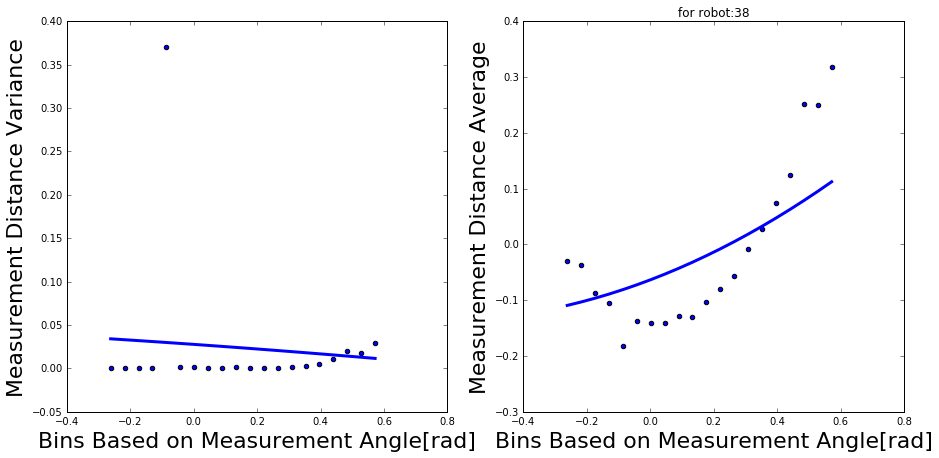

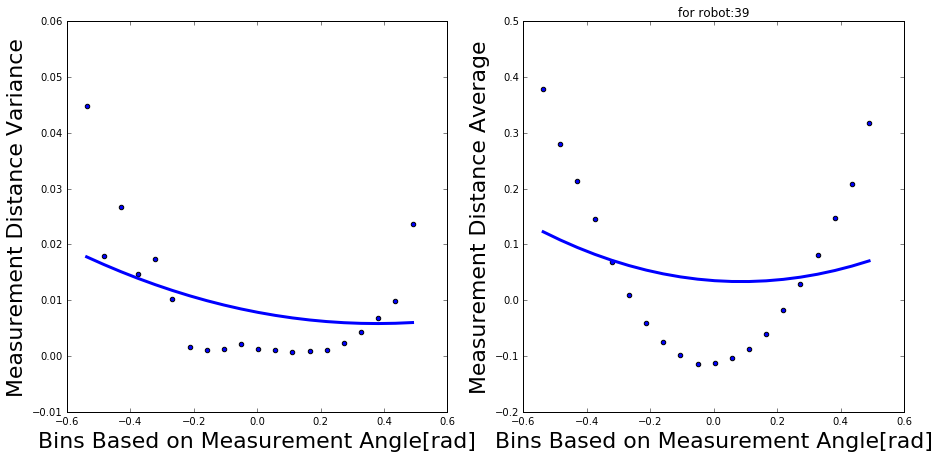

In [10]:
#Bins for every robot parab
with open('saved_angle_dist_sepR.bins','rb') as f:
    (angleError,distErr)=pickle.load(f)

print(len(angleError))
for ind,aKey in enumerate(angleError):
    angleErr=aKey
    indsAng=np.abs(angleErr[:,1])<1.2
#     angleErr=angleErr[indsAng]
    
    binAcount=20
    binARes=makeBins(angleErr,binAcount,1)
    dobinDist=True

    if  dobinDist:
        fontSize=22
        f, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,7))
    #     plt.subplot(211)
    #     plt.title("Distance Error Var")
        plt.title("for robot:{}".format(ind))
        ax1.scatter(binARes[:,0],binARes[:,1])
        ax1.plot(binARes[:,0], binARes[:,4], color='blue',
                 linewidth=3)
        ax1.set_xlabel("Bins Based on Measurement Angle[rad]",fontsize=fontSize)
        ax1.set_ylabel("Measurement Distance Variance",fontsize=fontSize)
    #     plt.subplot(221)
    #     plt.title("Distance Error Average")
        ax2.scatter(binARes[:,0],binARes[:,3])
        ax2.set_xlabel("Bins Based on Measurement Angle[rad]",fontsize=fontSize)
        ax2.set_ylabel("Measurement Distance Average",fontsize=fontSize)

        print('model shapes',binARes[:,0].reshape(-1,1).shape, binARes[:,3].shape)
        model = make_pipeline(PolynomialFeatures(2), Ridge())
        svrRes=model.fit(binARes[:,0].reshape(-1,1), binARes[:,3]).predict(binARes[:,0].reshape(-1,1))
        plt.plot(binARes[:,0], svrRes, color='blue',
                 linewidth=3)
        ax2.plot(binARes[:,0], binARes[:,5], color='blue',
                 linewidth=3)

   

shapes diabetes (422, 1) (422,)
Coefficients: 
 [ 938.23786125]
Residual sum of squares: 2548.07
Variance score: 0.47


([], <a list of 0 Text yticklabel objects>)

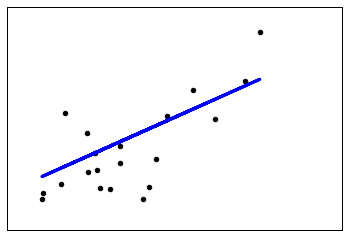

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()
print('shapes diabetes',diabetes_X_train.shape,diabetes_y_train.shape)
# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(diabetes_X_test) - diabetes_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(diabetes_X_test, diabetes_y_test))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, regr.predict(diabetes_X_test), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

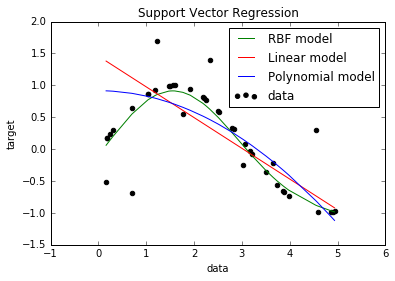

In [101]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

###############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

###############################################################################
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))

###############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

###############################################################################
# look at the results
plt.scatter(X, y, c='k', label='data')
plt.hold('on')
plt.plot(X, y_rbf, c='g', label='RBF model')
plt.plot(X, y_lin, c='r', label='Linear model')
plt.plot(X, y_poly, c='b', label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()